# Orbital Anomaly Detection using Two-Line Element (TLE) Data

## 1. Introduction & Problem Statement
Orbital debris and the increasing complexity of space operations necessitate robust, autonomous methods for monitoring Resident Space Objects (RSOs). This project focuses on developing a Machine Learning (ML) framework for detecting orbital anomalies (such as maneuvers or re-evaluations) using two-line element (TLE) data.

The project utilizes TLE data for diverse orbital regimes:
- **ISS (Low Earth Orbit, LEO):** A known maneuvering satellite.
- **ASTRA 2F (Geostationary Orbit, GEO):** Known for stable-drift behavior.
- **ARIANE 5 DEB and SL-8 DEB (Debris):** Representing less stable, unpropelled objects.

### Objectives
1. **Data Exploration:** Analyze raw TLE parameters and their statistical distributions.
2. **Feature Engineering:** Transform raw parameters into physically meaningful features (e.g., Orbital Energy).
3. **Baseline Comparison:** Establish a simple statistical baseline for anomaly detection.
4. **Unsupervised Learning:** Implement Isolation Forest and DBSCAN to detect anomalies without prior labels.
5. **Active Learning (Advanced):** Improve the model using a semi-supervised feedback loop.

# PART 1: SETUP AND DATA LOADING

In [36]:
# ==============================================================================
# GLOBAL IMPORTS
# ==============================================================================

# 1. Standard Library & Core Data Science
# ------------------------------------------------------------------------------
import io
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
from scipy.stats import uniform, loguniform
import warnings

# 2. Visualization
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, Markdown

# 3. Scikit-Learn: Preprocessing & Feature Engineering
# ------------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# 4. Scikit-Learn: Models (Unsupervised & Anomaly Detection)
# ------------------------------------------------------------------------------
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

# 5. Scikit-Learn: Model Selection & Inspection
# ------------------------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.inspection import permutation_importance

# 6. Scikit-Learn: Metrics & Evaluation
# ------------------------------------------------------------------------------
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    precision_recall_curve,
    auc,
    average_precision_score
)

# ==============================================================================
# CONFIGURATION 
# ==============================================================================
# Set pandas options for better display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Suppress warnings that clutter the notebook
warnings.filterwarnings('ignore')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
csv_files = [
    "ISS(ZARYA)_25544_data.csv",
    "ASTRA 2F_38778_data.csv",
    "ARIANE 5 DEB (SYLDA)_44336_data.csv",
    "SL-8 DEB_4084_data.csv"
]
dataframes = {}
for file_name in csv_files:
    filepath = "DATASET/"+file_name
    df_name=file_name.replace(".csv","")
    dataframes[df_name] = pd.read_csv(filepath)
    print(f"{df_name} (Shape: {dataframes[df_name].shape})")

ISS(ZARYA)_25544_data (Shape: (4540, 32))
ASTRA 2F_38778_data (Shape: (1677, 32))
ARIANE 5 DEB (SYLDA)_44336_data (Shape: (1768, 32))
SL-8 DEB_4084_data (Shape: (1383, 32))


# PART 2: DATA CLEANING (All Satellites)

## Remove Constant Columns

In [3]:
drop_summary = []

for name, df in dataframes.items():
    # Identify constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() == 1 and (col not in ['NORAD_CAT_ID', 'OBJECT_NAME', 'OBJECT_TYPE'])]
    
    if constant_cols:
        # Store information before dropping
        drop_summary.append({
            'DataFrame': name,
            'Dropped Count': len(constant_cols),
            'Dropped Columns': ", ".join(constant_cols)
        })
        
        # Perform the drop
        df.drop(columns=constant_cols, inplace=True)

# Create a summary DataFrame
if drop_summary:
    df_report = pd.DataFrame(drop_summary)
    
    # Display the report styled for readability
    display(df_report.style.set_properties(subset=['Dropped Columns'], **{'text-align': 'left', 'white-space': 'pre-wrap'}))

,DataFrame,Dropped Count,Dropped Columns
0,ISS(ZARYA)_25544_data,11,"COMMENT, ORIGINATOR, CLASSIFICATION_TYPE, INTLDES, EPHEMERIS_TYPE, ELEMENT_SET_NO, MEAN_MOTION_DDOT, TLE_LINE0, OBJECT_ID, OBJECT_NUMBER, DECAYED"
1,ASTRA 2F_38778_data,12,"COMMENT, ORIGINATOR, CLASSIFICATION_TYPE, INTLDES, EPHEMERIS_TYPE, ELEMENT_SET_NO, BSTAR, MEAN_MOTION_DDOT, TLE_LINE0, OBJECT_ID, OBJECT_NUMBER, DECAYED"
2,ARIANE 5 DEB (SYLDA)_44336_data,11,"COMMENT, ORIGINATOR, CLASSIFICATION_TYPE, INTLDES, EPHEMERIS_TYPE, ELEMENT_SET_NO, MEAN_MOTION_DDOT, TLE_LINE0, OBJECT_ID, OBJECT_NUMBER, DECAYED"
3,SL-8 DEB_4084_data,11,"COMMENT, ORIGINATOR, CLASSIFICATION_TYPE, INTLDES, EPHEMERIS_TYPE, ELEMENT_SET_NO, MEAN_MOTION_DDOT, TLE_LINE0, OBJECT_ID, OBJECT_NUMBER, DECAYED"


## Remove Metadata Columns

In [4]:
# Define the list of columns to target
target_cols = ['REV_AT_EPOCH', 'FILE', 'TLE_LINE1', 'TLE_LINE2']
drop_log = []

for name, df in dataframes.items():
    # Identify columns that exist in this dataframe
    cols_to_drop = [col for col in target_cols if col in df.columns]
    
    if cols_to_drop:
        # Log the action
        drop_log.append({
            'DataFrame': name,
            'Dropped Columns': ", ".join(cols_to_drop),
            'Count': len(cols_to_drop),
        })
        
        # Perform the drop
        df.drop(columns=cols_to_drop, inplace=True)

# Display the summary if any columns were dropped
if drop_log:
    summary_df = pd.DataFrame(drop_log)
    display(summary_df.style.set_caption("Cleaned Columns Report"))
else:
    print("No specified columns were found to drop.")

,DataFrame,Dropped Columns,Count
0,ISS(ZARYA)_25544_data,"REV_AT_EPOCH, FILE, TLE_LINE1, TLE_LINE2",4
1,ASTRA 2F_38778_data,"REV_AT_EPOCH, FILE, TLE_LINE1, TLE_LINE2",4
2,ARIANE 5 DEB (SYLDA)_44336_data,"REV_AT_EPOCH, FILE, TLE_LINE1, TLE_LINE2",4
3,SL-8 DEB_4084_data,"REV_AT_EPOCH, FILE, TLE_LINE1, TLE_LINE2",4


## Convert EPOCH to DateTime

In [5]:
conversion_log = []

for name, df in dataframes.items():
    if 'EPOCH' in df.columns:
        # Convert to datetime
        df['EPOCH'] = pd.to_datetime(df['EPOCH'])
        
        # Log statistics to verify the conversion worked correctly
        conversion_log.append({
            'DataFrame': name,
            'Dtype': df['EPOCH'].dtype,
            'Start Date': df['EPOCH'].min(),
            'End Date': df['EPOCH'].max(),
            'NaT Count': df['EPOCH'].isnull().sum() # Check for failed conversions
        })

# Display summary
if conversion_log:
    summary_df = pd.DataFrame(conversion_log)
    display(summary_df.style.format({
        'Start Date': '{:%Y-%m-%d %H:%M}', 
        'End Date': '{:%Y-%m-%d %H:%M}'
    }))
else:
    print("Column 'EPOCH' not found in any DataFrame.")

,DataFrame,Dtype,Start Date,End Date,NaT Count
0,ISS(ZARYA)_25544_data,datetime64[ns],2023-01-01 06:28,2024-12-30 20:18,0
1,ASTRA 2F_38778_data,datetime64[ns],2023-01-01 08:31,2024-12-30 21:27,0
2,ARIANE 5 DEB (SYLDA)_44336_data,datetime64[ns],2023-01-01 09:34,2024-12-30 22:35,0
3,SL-8 DEB_4084_data,datetime64[ns],2023-01-01 10:54,2024-12-30 21:34,0


## Merge Dataset

In [6]:
df_iss = dataframes["ISS(ZARYA)_25544_data"].copy()
df_astra_2f = dataframes["ASTRA 2F_38778_data"].copy()
df_ariane_5_deb = dataframes["ARIANE 5 DEB (SYLDA)_44336_data"].copy()
df_sl8_deb = dataframes["SL-8 DEB_4084_data"].copy()

df_combined = pd.concat([df_iss, df_astra_2f,df_ariane_5_deb,df_sl8_deb], ignore_index=True)
df_combined.head()

,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,BSTAR,MEAN_MOTION_DOT,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE
0,25544,ISS (ZARYA),PAYLOAD,2023-01-01 06:28:40,541088,15.498110,0.000520,51.6448,75.3411,209.5406,257.0907,0.000289,0.000160,6795.415,92.915,420.817,413.744
1,25544,ISS (ZARYA),PAYLOAD,2023-01-01 12:46:48,697248,15.498233,0.000521,51.6444,74.0407,211.7305,280.9843,0.000302,0.000167,6795.379,92.914,420.786,413.703
2,25544,ISS (ZARYA),PAYLOAD,2023-01-01 17:28:45,194304,15.498321,0.000515,51.6445,73.0716,212.0396,293.8042,0.000310,0.000172,6795.354,92.913,420.721,413.717
3,25544,ISS (ZARYA),PAYLOAD,2023-01-02 00:52:04,330272,15.498430,0.000516,51.6446,71.5466,213.3191,211.3400,0.000310,0.000172,6795.322,92.913,420.696,413.678
4,25544,ISS (ZARYA),PAYLOAD,2023-01-02 05:40:34,178880,15.498507,0.000513,51.6447,70.5542,214.4037,248.8124,0.000313,0.000173,6795.299,92.912,420.650,413.679


# PART 3: EXPLORATORY DATA ANALYSIS (All Satellites)

This section explores all four satellites to understand their orbital characteristics.

In [7]:
def generate_orbital_report(df):
    stats = df.describe()
    report = ""

    # 1. Orbital Stability Section
    # Columns expected to be stable (low standard deviation)
    stable_cols = ['INCLINATION', 'SEMIMAJOR_AXIS', 'PERIOD', 'MEAN_MOTION']
    report += "### Orbital Stability\n"
    
    for col in stable_cols:
        if col in stats.columns:
            std_val = stats.loc['std', col]
            report += f"- **{col}**: Very stable with a standard deviation of **{std_val:.6f}**.\n"

    # 2. Variability Section
    # Columns expected to vary (high standard deviation) due to physics
    var_cols = {
        'RA_OF_ASC_NODE': "likely due to orbital precession",
        'ARG_OF_PERICENTER': "indicating significant variations in the argument of perigee",
        'MEAN_ANOMALY': "indicating significant variations in the mean anomaly"
    }
    report += "\n### Variability in Certain Columns\n"
    
    for col, explanation in var_cols.items():
        if col in stats.columns:
            std_val = stats.loc['std', col]
            report += f"- **{col}**: High variability with a standard deviation of **{std_val:.6f}**, {explanation}.\n"

    # 3. Eccentricity Section
    if 'ECCENTRICITY' in stats.columns:
        mean_ecc = stats.loc['mean', 'ECCENTRICITY']
        std_ecc = stats.loc['std', 'ECCENTRICITY']
        
        # Determine orbit shape description
        shape_desc = "nearly circular" if mean_ecc < 0.01 else "elliptical"
        
        report += "\n### Low Eccentricity\n"
        report += f"- **ECCENTRICITY**: Very low on average (**{mean_ecc:.6f}**) with a standard deviation of **{std_ecc:.6f}**, indicating a {shape_desc} orbit.\n"

    # 4. Drag Coefficient (BSTAR) Section
    if 'BSTAR' in stats.columns:
        mean_bstar = stats.loc['mean', 'BSTAR']
        std_bstar = stats.loc['std', 'BSTAR']
        
        report += "\n### Drag Coefficient (BSTAR)\n"
        report += f"- **BSTAR**: Average of **{mean_bstar:.6f}** with a standard deviation of **{std_bstar:.6f}**. This may indicate variations in atmospheric drag or solar radiation pressure.\n"

    return report

# Usage loop
for name, df in dataframes.items():
    display(Markdown(f"## Analysis for {name.upper()}"))
    
    # Generate the text report
    md_content = generate_orbital_report(df)
    
    # Render the Markdown
    display(Markdown(md_content))
    
    # Separator
    display(Markdown("---"))

## Analysis for ISS(ZARYA)_25544_DATA

### Orbital Stability
- **INCLINATION**: Very stable with a standard deviation of **0.002056**.
- **SEMIMAJOR_AXIS**: Very stable with a standard deviation of **1.547024**.
- **PERIOD**: Very stable with a standard deviation of **0.031734**.
- **MEAN_MOTION**: Very stable with a standard deviation of **0.005294**.

### Variability in Certain Columns
- **RA_OF_ASC_NODE**: High variability with a standard deviation of **105.642251**, likely due to orbital precession.
- **ARG_OF_PERICENTER**: High variability with a standard deviation of **116.356581**, indicating significant variations in the argument of perigee.
- **MEAN_ANOMALY**: High variability with a standard deviation of **108.566872**, indicating significant variations in the mean anomaly.

### Low Eccentricity
- **ECCENTRICITY**: Very low on average (**0.000538**) with a standard deviation of **0.000271**, indicating a nearly circular orbit.

### Drag Coefficient (BSTAR)
- **BSTAR**: Average of **0.000290** with a standard deviation of **0.002100**. This may indicate variations in atmospheric drag or solar radiation pressure.


---

## Analysis for ASTRA 2F_38778_DATA

### Orbital Stability
- **INCLINATION**: Very stable with a standard deviation of **0.019815**.
- **SEMIMAJOR_AXIS**: Very stable with a standard deviation of **0.613708**.
- **PERIOD**: Very stable with a standard deviation of **0.031355**.
- **MEAN_MOTION**: Very stable with a standard deviation of **0.000022**.

### Variability in Certain Columns
- **RA_OF_ASC_NODE**: High variability with a standard deviation of **8.688684**, likely due to orbital precession.
- **ARG_OF_PERICENTER**: High variability with a standard deviation of **144.510482**, indicating significant variations in the argument of perigee.
- **MEAN_ANOMALY**: High variability with a standard deviation of **102.384626**, indicating significant variations in the mean anomaly.

### Low Eccentricity
- **ECCENTRICITY**: Very low on average (**0.000300**) with a standard deviation of **0.000136**, indicating a nearly circular orbit.


---

## Analysis for ARIANE 5 DEB (SYLDA)_44336_DATA

### Orbital Stability
- **INCLINATION**: Very stable with a standard deviation of **0.093529**.
- **SEMIMAJOR_AXIS**: Very stable with a standard deviation of **1662.318261**.
- **PERIOD**: Very stable with a standard deviation of **54.676155**.
- **MEAN_MOTION**: Very stable with a standard deviation of **0.551316**.

### Variability in Certain Columns
- **RA_OF_ASC_NODE**: High variability with a standard deviation of **100.012102**, likely due to orbital precession.
- **ARG_OF_PERICENTER**: High variability with a standard deviation of **107.834137**, indicating significant variations in the argument of perigee.
- **MEAN_ANOMALY**: High variability with a standard deviation of **146.170547**, indicating significant variations in the mean anomaly.

### Low Eccentricity
- **ECCENTRICITY**: Very low on average (**0.631013**) with a standard deviation of **0.035344**, indicating a elliptical orbit.

### Drag Coefficient (BSTAR)
- **BSTAR**: Average of **0.011322** with a standard deviation of **0.002814**. This may indicate variations in atmospheric drag or solar radiation pressure.


---

## Analysis for SL-8 DEB_4084_DATA

### Orbital Stability
- **INCLINATION**: Very stable with a standard deviation of **0.001309**.
- **SEMIMAJOR_AXIS**: Very stable with a standard deviation of **0.479588**.
- **PERIOD**: Very stable with a standard deviation of **0.010062**.
- **MEAN_MOTION**: Very stable with a standard deviation of **0.001463**.

### Variability in Certain Columns
- **RA_OF_ASC_NODE**: High variability with a standard deviation of **108.478470**, likely due to orbital precession.
- **ARG_OF_PERICENTER**: High variability with a standard deviation of **105.191911**, indicating significant variations in the argument of perigee.
- **MEAN_ANOMALY**: High variability with a standard deviation of **105.323337**, indicating significant variations in the mean anomaly.

### Low Eccentricity
- **ECCENTRICITY**: Very low on average (**0.002190**) with a standard deviation of **0.000085**, indicating a nearly circular orbit.

### Drag Coefficient (BSTAR)
- **BSTAR**: Average of **0.000104** with a standard deviation of **0.000053**. This may indicate variations in atmospheric drag or solar radiation pressure.


---

## Correlation between variables

In [8]:
def matrice_corr_comparative(df_combined, features):
    objects = df_combined['OBJECT_NAME'].unique()
    n_objects = len(objects)

    n_cols = 2
    n_rows = (n_objects + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 9, n_rows * 8))
    axes = axes.flatten()

    for i, obj_name in enumerate(objects):
        ax = axes[i]

        df_obj = df_combined[df_combined['OBJECT_NAME'] == obj_name]

        corr_matrix = df_obj[features].corr()

        sns.heatmap(
            corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='vlag',
            vmin=-1, vmax=1,
            ax=ax,
            linewidths=.5,
            annot_kws={"size": 8}
        )

        ax.set_title(f'Correlation matrix - {obj_name}', fontsize=14)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()

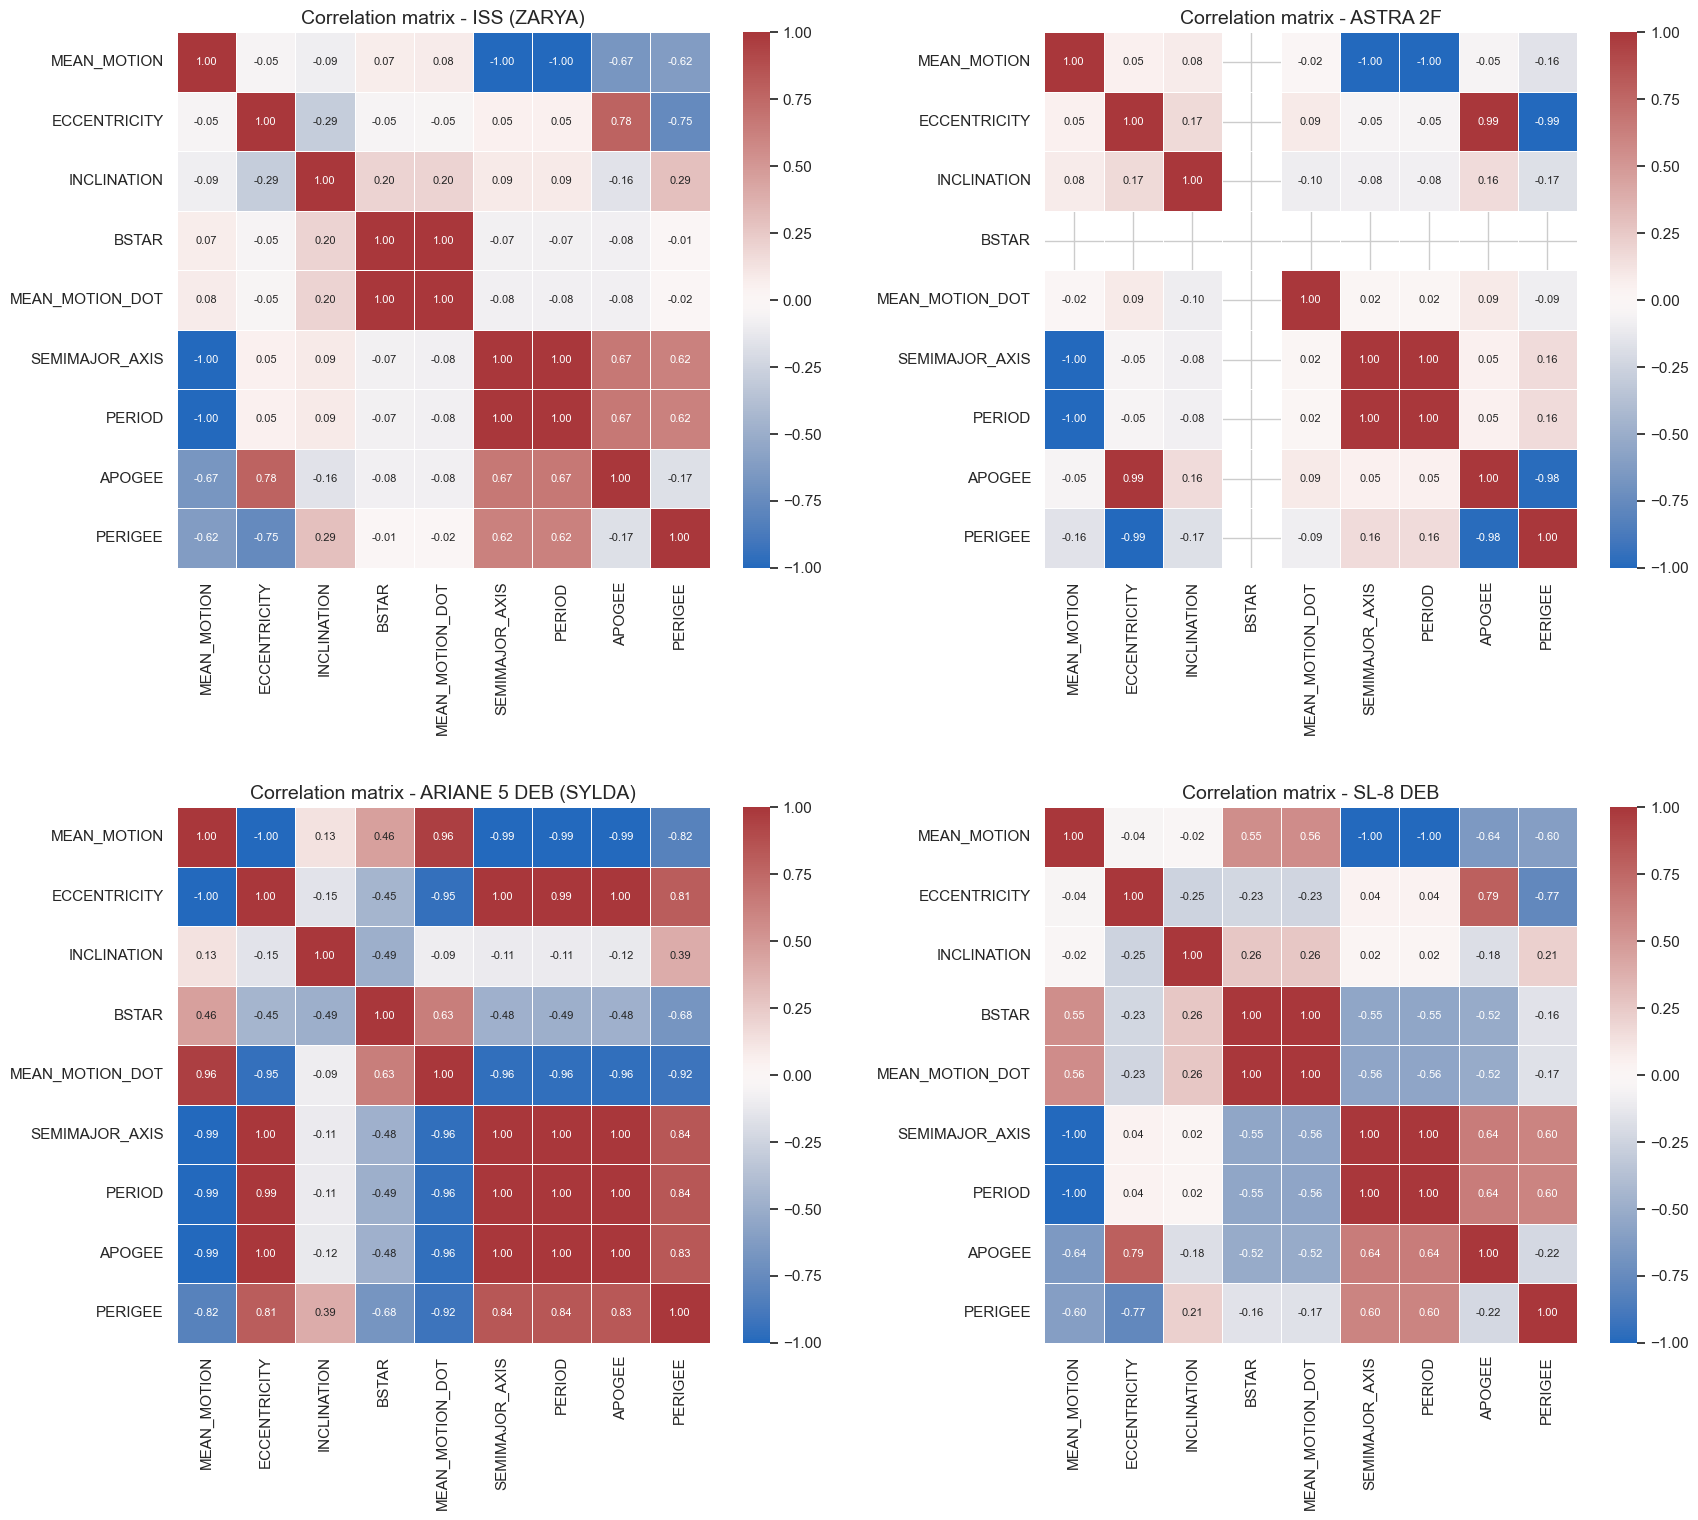

In [9]:
key_cols = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR',
            'MEAN_MOTION_DOT', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOGEE', 'PERIGEE']
matrice_corr_comparative(df_combined, key_cols)

## 2. Orbital Trajectories Visualization Over Time

In [10]:
def plot_traj_orbitale_comparative(df_combined, feature):

    print(f"Displaying evolution of: {feature}")

    g = sns.relplot(
        data=df_combined,
        x='EPOCH',
        y=feature,
        hue='OBJECT_NAME',
        col='OBJECT_NAME',
        col_wrap=2,
        kind='line',
        height=4,
        aspect=2,
        palette='tab10',
        lw=1,
        facet_kws={'sharey': False, 'sharex': True}
    )

    g.fig.suptitle(f'Temporal evolution of {feature} (by Object)', y=1.03, fontsize=16)
    g.set_axis_labels('Date (EPOCH)', feature)

    plt.show()

In [11]:
metrics = ["APOGEE", "PERIGEE", "MEAN_MOTION", "ECCENTRICITY"]

# Create an Output widget for each metric to capture the plot
outputs = [widgets.Output() for _ in metrics]

# Generate plots inside the corresponding Output widget
for metric, out in zip(metrics, outputs):
    with out:
        # The function output is captured here instead of being printed globally
        plot_traj_orbitale_comparative(df_combined, metric)

# Create the Tab widget
tabs = widgets.Tab(children=outputs)

# Set titles for each tab
for i, metric in enumerate(metrics):
    tabs.set_title(i, metric.replace('_', ' ').title())

# Display the interactive tabs
display(tabs)

## 3. Data Quality: The Histogram of Temporal Gaps

In [12]:
def analyze_time_gaps_interactive(df_iss):
    objects = df_combined['OBJECT_NAME'].unique()
    
    # Create a list to hold the Output widgets (tabs)
    tab_outputs = []
    
    for obj_name in objects:
        out = widgets.Output()
        
        with out:
            # 1. Data Preparation
            df_obj = df_combined[df_combined['OBJECT_NAME'] == obj_name].copy()
            df_obj = df_obj.sort_values('EPOCH').reset_index(drop=True)
            
            # Calculate gaps in hours
            time_diffs_hours = df_obj['EPOCH'].diff().dt.total_seconds() / 3600
            clean_time_diffs = time_diffs_hours.dropna()
            clean_time_diffs = clean_time_diffs[clean_time_diffs > 0]
            aligned_dates = df_obj['EPOCH'][clean_time_diffs.index]
            
            if len(clean_time_diffs) == 0:
                print("Insufficient data for analysis.")
                tab_outputs.append(out)
                continue

            # 2. Statistics Display (as a DataFrame instead of print statements)
            stats = pd.DataFrame({
                'Metric': ['Average Gap', 'Median Gap', 'Min Gap', 'Max Gap', 'Std Dev', 'Count'],
                'Value': [
                    f"{clean_time_diffs.mean():.2f} h",
                    f"{clean_time_diffs.median():.2f} h",
                    f"{clean_time_diffs.min():.2f} h",
                    f"{clean_time_diffs.max():.2f} h",
                    f"{clean_time_diffs.std():.2f} h",
                    f"{len(clean_time_diffs)}"
                ]
            }).set_index('Metric')
            
            # Display stats nicely
            display(stats.T.style.set_caption(f"Statistics for {obj_name}"))
            
            # 3. Visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Histogram
            ax1.hist(clean_time_diffs, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
            ax1.set_xlabel('Time Gap (hours)')
            ax1.set_ylabel('Frequency')
            ax1.set_title('Distribution of Time Gaps')
            ax1.set_xscale('log')
            ax1.axvline(clean_time_diffs.mean(), color='red', linestyle='--', label='Mean')
            ax1.axvline(clean_time_diffs.median(), color='green', linestyle='--', label='Median')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Scatter (Temporal Evolution)
            ax2.scatter(aligned_dates, clean_time_diffs, alpha=0.5, s=10, color='darkblue')
            ax2.set_xlabel('Date')
            ax2.set_ylabel('Time Gap (hours)')
            ax2.set_title('Temporal Evolution of Gaps')
            ax2.set_yscale('log')
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        tab_outputs.append(out)

    # Create the Tab widget
    tabs = widgets.Tab(children=tab_outputs)
    for i, obj_name in enumerate(objects):
        tabs.set_title(i, obj_name)
        
    display(tabs)

# Usage
analyze_time_gaps_interactive(df_combined)

## 4. Distributions (KDE)

In [13]:
def kde_distrib_comparative(df_iss, feature):
    print(f"--- Distribution analysis: {feature} ---")

    g = sns.displot(
        data=df_combined,
        x=feature,
        col="OBJECT_NAME",
        col_wrap=3,
        kind="kde",
        fill=True,
        rug=False,
        height=4,
        aspect=1.5,
        facet_kws={'sharex': False, 'sharey': False}
    )

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f'Comparative distribution of: {feature}', fontsize=16)

    for ax in g.axes.flat:
        # Bug with groupby which order is not guaranteed
        title = ax.get_title()
        obj_name = title.split('=')[-1].strip()
        sub_df = df_combined[df_combined["OBJECT_NAME"] == obj_name]
        mean_val = sub_df[feature].mean()
        std_val = sub_df[feature].std()
        ax.text(0.95, 0.95, f'μ={mean_val:.6f}\nσ={std_val:.6f}',
                transform=ax.transAxes, ha='right', va='top', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.show()

In [14]:
# List of metrics to plot
metrics = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION']

# Create an Output widget for each metric
outputs = [widgets.Output() for _ in metrics]

# Generate plots inside the corresponding Output widget
for metric, out in zip(metrics, outputs):
    with out:
        # Capture the plot output
        kde_distrib_comparative(df_combined, metric)

# Create the Tab widget
tabs = widgets.Tab(children=outputs)

# Set titles for each tab (formatting the string for better readability)
for i, metric in enumerate(metrics):
    tabs.set_title(i, metric.replace('_', ' ').title())

# Display the interactive tabs
display(tabs)

## 5. Scatter Plots

In [15]:
def scatter_plot_comparative(df_combined, feature1, feature2):
    g = sns.relplot(
        data=df_combined,
        x=feature1,
        y=feature2,
        hue='OBJECT_NAME',
        col='OBJECT_NAME',
        col_wrap=2,
        palette='tab10',
        alpha=0.6,
        facet_kws={'sharey': False, 'sharex': False}
    )
    g.fig.suptitle(f'{feature1} vs {feature2} (by Objet)', y=1.03, fontsize=16)

    plt.show()

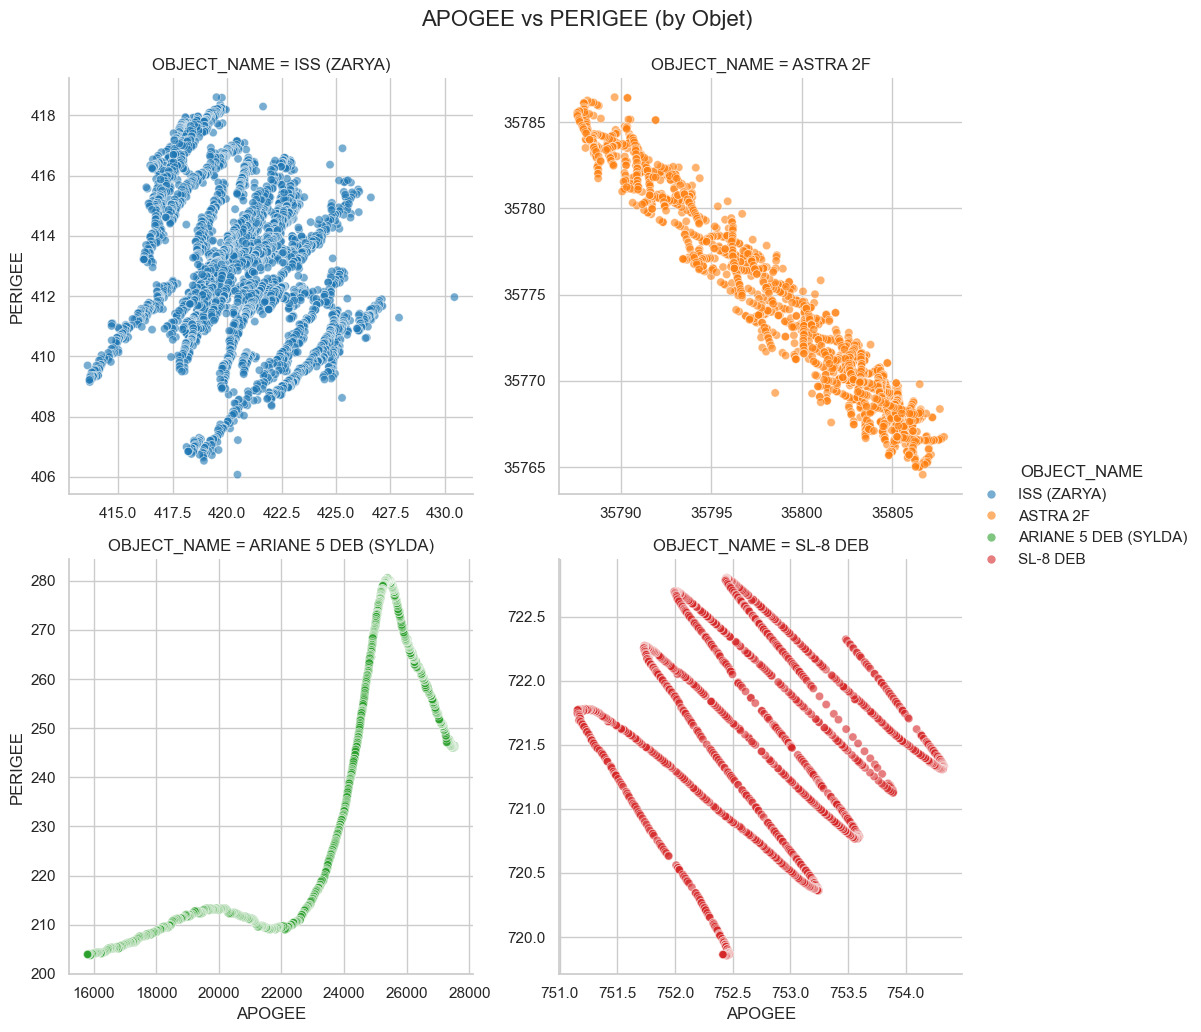

In [16]:
scatter_plot_comparative(df_combined, 'APOGEE', 'PERIGEE')

## 6. Polar Chart

In [17]:
def plot_polar_raan_comparative_with_epoch(df_combined):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='polar')

    objects = df_combined['OBJECT_NAME'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(objects)))

    for i, obj in enumerate(objects):
        df_obj = df_combined[df_combined['OBJECT_NAME'] == obj]

        theta = np.deg2rad(df_obj['RA_OF_ASC_NODE'])

        epoch_numeric = df_obj['EPOCH'].astype(np.int64)

        min_epoch = epoch_numeric.min()
        max_epoch = epoch_numeric.max()

        if max_epoch == min_epoch:
             r = np.full_like(theta, 1.0)
        else:
             r = 0.2 + 0.8 * (epoch_numeric - min_epoch) / (max_epoch - min_epoch)

        ax.scatter(theta, r, label=obj, s=10, alpha=0.7, color=colors[i])

    ax.set_title("Orbital Precession: RAAN vs. Time (Epoch)", va='bottom', fontsize=16)

    ax.set_rticks([0.2, 0.6, 1.0])
    ax.set_rlabel_position(22.5)
    ax.set_rlim(0, 1.1)

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    plt.legend(bbox_to_anchor=(1.1, 1.1))
    plt.show()

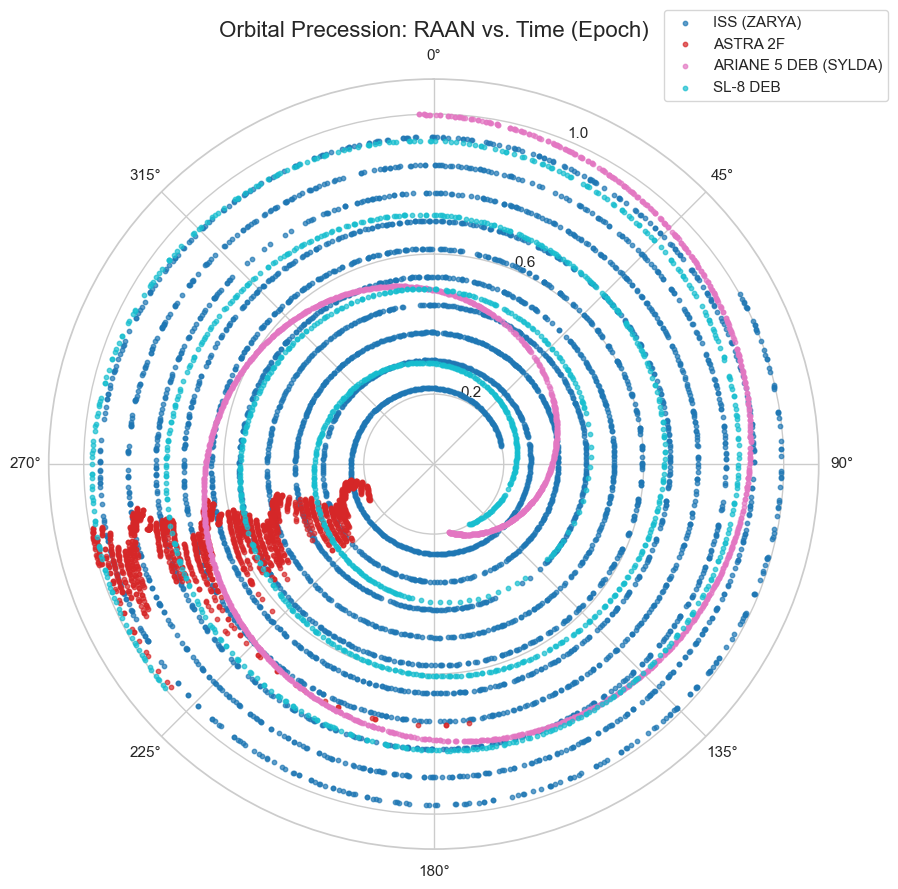

In [18]:
plot_polar_raan_comparative_with_epoch(df_combined)

# Focus on ISS (ZARYA)

The detailed analysis in this report focuses exclusively on the **International Space Station (ISS)** due to its well-documented operational history, frequent maneuvers (reboosts), and high observation density. The ISS provides an ideal benchmark for validating anomaly detection algorithms against known operational events.

From this point forward, all modeling and evaluation will be performed on ISS data only.
---

# PART 4: FEATURE ENGINEERING (ISS Only)

In [19]:
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

def compute_temporal_features(df):
    """Calculates temporal variations of orbital parameters."""
    df = df.copy()
    df = df.sort_values('EPOCH').reset_index(drop=True)

    # Calculate time deltas (in hours)
    df['TIME_DELTA'] = df['EPOCH'].diff().dt.total_seconds() / 3600

    # Features for temporal derivation
    orbital_params = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION',
                      'SEMIMAJOR_AXIS', 'APOGEE', 'PERIGEE']

    for param in orbital_params:
        # Rate of change (first derivative)
        df[f'{param}_RATE'] = df[param].diff() / df['TIME_DELTA']

        # Acceleration (second derivative)
        df[f'{param}_ACCEL'] = df[f'{param}_RATE'].diff() / df['TIME_DELTA']

        # Moving averages (10-observation window)
        df[f'{param}_MA10'] = df[param].rolling(window=10, min_periods=1).mean()

        # Deviation from moving average
        df[f'{param}_DEV_MA'] = df[param] - df[f'{param}_MA10']

    return df

def compute_orbital_energy(df):
    """Calculates specific orbital energy."""
    df = df.copy()
    # E = -μ / (2a) where μ = 398600.4418 km³/s² (Earth's gravitational constant)
    mu = 398600.4418
    df['ORBITAL_ENERGY'] = -mu / (2 * df['SEMIMAJOR_AXIS'])
    df['ENERGY_RATE'] = df['ORBITAL_ENERGY'].diff() / df['TIME_DELTA']
    return df

def compute_angular_features(df):
    """Processes angles using circular statistics."""
    df = df.copy()
    angular_params = ['RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY']

    for param in angular_params:
        # Conversion to Cartesian coordinates
        rad = np.deg2rad(df[param])
        df[f'{param}_SIN'] = np.sin(rad)
        df[f'{param}_COS'] = np.cos(rad)

        # Angular rate of change
        diff_angle = df[param].diff()
        # Correction for 0°/360° discontinuity (phase wrap)
        diff_angle = np.where(diff_angle > 180, diff_angle - 360, diff_angle)
        diff_angle = np.where(diff_angle < -180, diff_angle + 360, diff_angle)
        df[f'{param}_ANGULAR_RATE'] = diff_angle / df['TIME_DELTA']

    return df

def compute_orbit_shape_features(df):
    """Calculates orbital shape indicators."""
    
    df = df.copy()

    # Focal distance
    df['FOCAL_DISTANCE'] = df['SEMIMAJOR_AXIS'] * df['ECCENTRICITY']

    # Approximate orbital perimeter (Ramanujan's formula)
    a = df['SEMIMAJOR_AXIS']
    b = a * np.sqrt(1 - df['ECCENTRICITY']**2)
    h = ((a - b)**2) / ((a + b)**2)
    df['ORBIT_PERIMETER'] = np.pi * (a + b) * (1 + (3*h) / (10 + np.sqrt(4 - 3*h)))

    # Circularity
    df['CIRCULARITY'] = 1 - df['ECCENTRICITY']

    return df

def compute_drag_indicators(df):
    """Calculates indicators related to atmospheric drag."""
    df = df.copy()
    df['BSTAR_RATE'] = df['BSTAR'].diff() / df['TIME_DELTA']
    df['ALTITUDE_DECAY'] = -df['SEMIMAJOR_AXIS_RATE']
    return df

def compute_statistical_features(df, window=20):
    """Calculates rolling statistics."""
    df = df.copy()
    key_params = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION']

    for param in key_params:
        df[f'{param}_STD{window}'] = df[param].rolling(window=window, min_periods=1).std()
        df[f'{param}_MIN{window}'] = df[param].rolling(window=window, min_periods=1).min()
        df[f'{param}_MAX{window}'] = df[param].rolling(window=window, min_periods=1).max()
        df[f'{param}_RANGE{window}'] = df[f'{param}_MAX{window}'] - df[f'{param}_MIN{window}']

    return df

# Application of feature engineering on ISS
print("\nApplying to ISS (ZARYA)")
df_iss_enriched = df_iss.copy()
df_iss_enriched = compute_temporal_features(df_iss_enriched)
print(" - Temporal features created")
df_iss_enriched = compute_orbital_energy(df_iss_enriched)
print(" - Orbital energy calculated")
df_iss_enriched = compute_angular_features(df_iss_enriched)
print(" - Angular features processed")
df_iss_enriched = compute_orbit_shape_features(df_iss_enriched)
print(" - Orbital shape features created")
df_iss_enriched = compute_drag_indicators(df_iss_enriched)
print(" - Drag indicators calculated")
df_iss_enriched = compute_statistical_features(df_iss_enriched)
print(" - Rolling statistical features created")

# Removing NaNs
initial_rows = len(df_iss_enriched)
df_iss_enriched = df_iss_enriched.dropna().reset_index(drop=True)
removed_rows = initial_rows - len(df_iss_enriched)
print(f"\nFinal Dataset: {df_iss_enriched.shape[0]} rows x {df_iss_enriched.shape[1]} columns")
print(f" ({removed_rows} rows with NaN removed)")

FEATURE ENGINEERING

Applying to ISS (ZARYA)
 - Temporal features created
 - Orbital energy calculated
 - Angular features processed
 - Orbital shape features created
 - Drag indicators calculated
 - Rolling statistical features created

Final Dataset: 4094 rows x 70 columns
 (446 rows with NaN removed)


In [20]:
df_iss_enriched.head()

,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,BSTAR,MEAN_MOTION_DOT,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,TIME_DELTA,MEAN_MOTION_RATE,MEAN_MOTION_ACCEL,MEAN_MOTION_MA10,MEAN_MOTION_DEV_MA,ECCENTRICITY_RATE,ECCENTRICITY_ACCEL,ECCENTRICITY_MA10,ECCENTRICITY_DEV_MA,INCLINATION_RATE,INCLINATION_ACCEL,INCLINATION_MA10,INCLINATION_DEV_MA,SEMIMAJOR_AXIS_RATE,SEMIMAJOR_AXIS_ACCEL,SEMIMAJOR_AXIS_MA10,SEMIMAJOR_AXIS_DEV_MA,APOGEE_RATE,APOGEE_ACCEL,APOGEE_MA10,APOGEE_DEV_MA,PERIGEE_RATE,PERIGEE_ACCEL,PERIGEE_MA10,PERIGEE_DEV_MA,ORBITAL_ENERGY,ENERGY_RATE,RA_OF_ASC_NODE_SIN,RA_OF_ASC_NODE_COS,RA_OF_ASC_NODE_ANGULAR_RATE,ARG_OF_PERICENTER_SIN,ARG_OF_PERICENTER_COS,ARG_OF_PERICENTER_ANGULAR_RATE,MEAN_ANOMALY_SIN,MEAN_ANOMALY_COS,MEAN_ANOMALY_ANGULAR_RATE,FOCAL_DISTANCE,ORBIT_PERIMETER,CIRCULARITY,BSTAR_RATE,ALTITUDE_DECAY,MEAN_MOTION_STD20,MEAN_MOTION_MIN20,MEAN_MOTION_MAX20,MEAN_MOTION_RANGE20,ECCENTRICITY_STD20,ECCENTRICITY_MIN20,ECCENTRICITY_MAX20,ECCENTRICITY_RANGE20,INCLINATION_STD20,INCLINATION_MIN20,INCLINATION_MAX20,INCLINATION_RANGE20
0,25544,ISS (ZARYA),PAYLOAD,2023-01-01 17:28:45,194304,15.498321,0.000515,51.6445,73.0716,212.0396,293.8042,0.000310,0.000172,6795.354,92.913,420.721,413.717,4.699167,0.000019,-1.774767e-07,15.498221,0.000099,-1.234261e-06,-2.862919e-07,0.000519,-0.000004,0.000021,0.000018,51.644567,-0.000067,-0.005320,0.000083,6795.382667,-0.028667,-0.013832,-0.001897,420.774667,-0.053667,0.002979,0.002018,413.721333,-0.004333,-29.328895,-0.000023,0.956669,0.291176,-0.206228,-0.530505,-0.847682,0.065778,-0.914930,0.403612,2.728122,3.501646,42696.465576,0.999485,1.706686e-06,0.005320,0.000106,15.49811,15.498321,0.000210,0.000003,0.000515,0.000521,0.000006,0.000208,51.6444,51.6448,0.0004
1,25544,ISS (ZARYA),PAYLOAD,2023-01-02 00:52:04,330272,15.498430,0.000516,51.6446,71.5466,213.3191,211.3400,0.000310,0.000172,6795.322,92.913,420.696,413.678,7.388611,0.000015,-5.310324e-07,15.498273,0.000156,1.488778e-07,1.871988e-07,0.000518,-0.000002,0.000014,-0.000001,51.644575,0.000025,-0.004331,0.000134,6795.367500,-0.045500,-0.003384,0.001414,420.755000,-0.059000,-0.005278,-0.001118,413.710500,-0.032500,-29.329033,-0.000019,0.948581,0.316533,-0.206399,-0.549301,-0.835624,0.173172,-0.520116,-0.854096,-11.160988,3.509104,42696.264502,0.999484,3.112899e-08,0.004331,0.000135,15.49811,15.498430,0.000319,0.000003,0.000515,0.000521,0.000006,0.000171,51.6444,51.6448,0.0004
2,25544,ISS (ZARYA),PAYLOAD,2023-01-02 05:40:34,178880,15.498507,0.000513,51.6447,70.5542,214.4037,248.8124,0.000313,0.000173,6795.299,92.912,420.650,413.679,4.808333,0.000016,2.863098e-07,15.498320,0.000187,-7.279029e-07,-1.823461e-07,0.000517,-0.000004,0.000021,0.000002,51.644600,0.000100,-0.004783,-0.000094,6795.353800,-0.054800,-0.009567,-0.001286,420.734000,-0.084000,0.000208,0.001141,413.704200,-0.025200,-29.329132,-0.000021,0.942957,0.332915,-0.206392,-0.565020,-0.825077,0.225567,-0.932402,-0.361423,7.793220,3.485309,42696.120027,0.999487,5.615251e-07,0.004783,0.000157,15.49811,15.498507,0.000397,0.000003,0.000513,0.000521,0.000008,0.000158,51.6444,51.6448,0.0004
3,25544,ISS (ZARYA),PAYLOAD,2023-01-02 10:15:12,441312,15.498577,0.000513,51.6446,69.6092,215.2634,232.7755,0.000315,0.000175,6795.279,92.912,420.628,413.660,4.577222,0.000015,-1.788647e-07,15.498363,0.000214,-4.369462e-08,1.494811e-07,0.000516,-0.000004,-0.000022,-0.000009,51.644600,0.000000,-0.004369,0.000090,6795.341333,-0.062333,-0.004806,0.001040,420.716333,-0.088333,-0.004151,-0.000952,413.696833,-0.036833,-29.329218,-0.000019,0.937338,0.348422,-0.206457,-0.577336,-0.816507,0.187821,-0.796271,-0.604940,-3.503632,3.483940,42695.994365,0.999487,4.041753e-07,0.004369,0.000175,15.49811,15.498577,0.000467,0.000004,0.000513,0.000521,0.000008,0.000141,51.6444,51.6448,0.0004
4,25544,ISS (ZARYA),PAYLOAD,2023-01-02 13:35:49,828416,15.498636,0.000503,51.6448,68.9190,218.0405,287.8557,0.000319,0.000177,6795.262

# PART 5: TEMPORAL SPLIT (Train / Validation / Test)
---

We use a **temporal split** to simulate real-world deployment:
- **Train:** January - October 2023
- **Validation:** November - December 2023 (for hyperparameter tuning)
- **Test:** Full year 2024 (final evaluation)

In [21]:
# Ensure 'EPOCH' is datetime
if not pd.api.types.is_datetime64_any_dtype(df_iss_enriched['EPOCH']):
    df_iss_enriched['EPOCH'] = pd.to_datetime(df_iss_enriched['EPOCH'])

# Define masks
train_mask = (df_iss_enriched['EPOCH'] >= '2023-01-01') & (df_iss_enriched['EPOCH'] <= '2023-10-31')
val_mask   = (df_iss_enriched['EPOCH'] >= '2023-11-01') & (df_iss_enriched['EPOCH'] <= '2023-12-31')
test_mask  = (df_iss_enriched['EPOCH'] >= '2024-01-01')

# Create DataFrames
df_train = df_iss_enriched[train_mask].copy()
df_val   = df_iss_enriched[val_mask].copy()
df_test  = df_iss_enriched[test_mask].copy()

# Create a summary table
total_rows = len(df_iss_enriched)
summary_data = [
    {
        "Split": "Train",
        "Rows": len(df_train),
        "Share (%)": (len(df_train) / total_rows) * 100,
        "Start Date": df_train['EPOCH'].min(),
        "End Date": df_train['EPOCH'].max()
    },
    {
        "Split": "Validation",
        "Rows": len(df_val),
        "Share (%)": (len(df_val) / total_rows) * 100,
        "Start Date": df_val['EPOCH'].min(),
        "End Date": df_val['EPOCH'].max()
    },
    {
        "Split": "Test",
        "Rows": len(df_test),
        "Share (%)": (len(df_test) / total_rows) * 100,
        "Start Date": df_test['EPOCH'].min(),
        "End Date": df_test['EPOCH'].max()
    }
]

summary_df = pd.DataFrame(summary_data)

# Display formatted table
format_dict = {'Share (%)': '{:.1f}%', 'Start Date': '{:%Y-%m-%d}', 'End Date': '{:%Y-%m-%d}'}
display(summary_df.style.format(format_dict).hide(axis='index'))

Split,Rows,Share (%),Start Date,End Date
Train,1621,39.6%,2023-01-01,2023-10-30
Validation,343,8.4%,2023-11-01,2023-12-30
Test,2119,51.8%,2024-01-01,2024-12-30


# PART 6: GROUND TRUTH GENERATION

Ground truth labels are generated using **physics-based rules** that detect:
- Significant altitude changes (maneuvers/reboosts)
- Unusual mean motion variations
- Energy changes indicating orbital modifications
- High drag events

# Physical Relationships Between Orbital Variables

---

### **Period – Semimajor Axis (Kepler's Third Law)**
$$
T = 2\pi \sqrt{\frac{a^3}{\mu}}
$$
- $ T $: Orbital period (**PERIOD**)
- $ a $: Semimajor axis (**SEMIMAJOR_AXIS**)
- $ \mu = GM $: Standard gravitational parameter of the central body (Earth for satellites)

---

### **Mean Motion – Semimajor Axis**
$$
n = \sqrt{\frac{\mu}{a^3}}
$$
- $ n $: Mean motion (**MEAN_MOTION**), or the number of orbits per unit time

---

### **Period – Mean Motion**
$$
T = \frac{2\pi}{n}
$$

---

### **Apogee, Perigee, Semimajor Axis, and Eccentricity**
$$
\begin{align*}
r_{\text{apogee}} &= a(1 + e) \\
r_{\text{perigee}} &= a(1 - e)
\end{align*}
$$
- $ e $: Eccentricity (**ECCENTRICITY**)
- $ r_{\text{apogee}} $: Apogee distance (**APOGEE**)
- $ r_{\text{perigee}} $: Perigee distance (**PERIGEE**)

---

### **Mean Motion Variation ($\dot{n}$), Drag (BSTAR), and Altitude Decay**
- $\dot{n}$ (**MEAN_MOTION_DOT**) and **BSTAR** (drag coefficient) describe the rate of orbital decay due to atmospheric drag, affecting the semimajor axis and thus the period over time:
$$
\frac{da}{dt} \sim -\frac{2a^2}{n\mu} F_D
$$
- The drag force $ F_D $ is modeled using **BSTAR**.

---

In [22]:
def create_ground_truth_labels(df, thresholds=None, verbose=False):
    """
    Generates ground truth labels and returns diagnostic stats.
    Updated to return statistics and rule counts for the dashboard.
    """
    # Default Thresholds
    if thresholds is None:
        thresholds = {
            'semimajor_rate': 0.3,
            'mean_motion_rate': 0.0001,
            'energy_rate': 0.01,
            'bstar_sigma': 3.5,          
            'altitude_jump': 0.5,        
            'apogee_jump': 2,          
            'perigee_jump': 2,         
            'accel_sigma': 2.5,          
        }

    # Calculate Statistics (Handling NaNs)
    stats = {
        'SEMIMAJOR_AXIS_RATE_std': df['SEMIMAJOR_AXIS_RATE'].std(),
        'MEAN_MOTION_RATE_std': df['MEAN_MOTION_RATE'].std(),
        'ENERGY_RATE_std': df['ENERGY_RATE'].std(),
        'BSTAR_mean': df['BSTAR'].mean(),
        'BSTAR_std': df['BSTAR'].std(),
        'ACCEL_std': df['SEMIMAJOR_AXIS_ACCEL'].std()
    }

    # Apply Rules (using fillna(False) to handle NaNs safely)
    rules = {
        'Altitude Jump': np.abs(df['SEMIMAJOR_AXIS_RATE']) > thresholds['semimajor_rate'],
        'Mean Motion Change': np.abs(df['MEAN_MOTION_RATE']) > thresholds['mean_motion_rate'],
        'Energy Change': np.abs(df['ENERGY_RATE']) > thresholds['energy_rate'],
        'High Drag': df['BSTAR'] > (stats['BSTAR_mean'] + thresholds['bstar_sigma'] * stats['BSTAR_std']),
        'Apogee Jump': np.abs(df['APOGEE'].diff()) > thresholds['apogee_jump'],
        'Perigee Jump': np.abs(df['PERIGEE'].diff()) > thresholds['perigee_jump'],
        'Orbital Accel': np.abs(df['SEMIMAJOR_AXIS_ACCEL']) > thresholds['accel_sigma'] * stats['ACCEL_std'],
        'Reboost': (df['APOGEE'].diff() > thresholds['altitude_jump']) & (df['PERIGEE'].diff() > thresholds['altitude_jump'])
    }

    # Aggregate Detections for the dashboard
    detection_counts = {k: v.fillna(False).sum() for k, v in rules.items()}
    
    # Generate Labels
    ground_truth = np.zeros(len(df), dtype=bool)
    detection_reasons = [[] for _ in range(len(df))]
    
    for rule_name, condition in rules.items():
        matches = condition.fillna(False).values
        ground_truth |= matches
        for idx, match in enumerate(matches):
            if match:
                detection_reasons[idx].append(rule_name)

    ground_truth_labels = np.where(ground_truth, -1, 1)

    return ground_truth_labels, detection_reasons, detection_counts, stats

In [23]:
print("=" * 60)
print("GROUND TRUTH GENERATION REPORT")
print("=" * 60)

# Create dataframes for each split (using temporal masks)
df_train = df_iss_enriched[train_mask].copy()
df_val = df_iss_enriched[val_mask].copy()
df_test = df_iss_enriched[test_mask].copy()

# 1. Processing Loop
datasets = {'Train': df_train, 'Validation': df_val, 'Test': df_test}
results_stats = {}
results_rules = {}
results_summary = []
reasons_storage = {}

for name, df in datasets.items():
    # Run function
    labels, reasons, rule_counts, stats = create_ground_truth_labels(df, verbose=False)
    
    # Update DataFrame
    df.loc[:, 'GT_LABEL'] = labels
    reasons_storage[name] = reasons
    
    # Collect Data for visualization
    results_stats[name] = stats
    results_rules[name] = rule_counts
    
    # Summary Data
    n_anomalies = np.sum(labels == -1)
    results_summary.append({
        'Dataset': name,
        'Rows': len(df),
        'Anomalies': n_anomalies,
        'Rate (%)': (n_anomalies / len(df)) * 100
    })

# Update the split dataframes with labels
df_train = datasets['Train']
df_val = datasets['Validation']
df_test = datasets['Test']

# Also update the main enriched dataframe
df_iss_enriched.loc[train_mask, 'GT_LABEL'] = df_train['GT_LABEL'].values
df_iss_enriched.loc[val_mask, 'GT_LABEL'] = df_val['GT_LABEL'].values
df_iss_enriched.loc[test_mask, 'GT_LABEL'] = df_test['GT_LABEL'].values

# 2. Display Applied Thresholds
print("\n1. APPLIED THRESHOLDS")
thresholds_display = {
    'Altitude Rate': '> 0.3 km/h',
    'Mean Motion': '> 0.0001 rev/day/h',
    'Energy Rate': '> 0.01 km²/s²/h',
    'High Drag': '> Mean + 3.5 std',
    'Apogee/Perigee Jump': '> 2 km',
    'Accel': '> 3.0 std'
}
print(pd.DataFrame(list(thresholds_display.items()), 
                   columns=['Parameter', 'Threshold']).to_string(index=False))

# 3. Display Statistics Comparison
print("\n2. DATASET STATISTICS COMPARISON")
df_stats_comp = pd.DataFrame(results_stats)
display(df_stats_comp.style.format("{:.6f}", na_rep="NaN"))

# 4. Display Rule Detections
print("\n3. DETECTIONS BY RULE")
df_rules_comp = pd.DataFrame(results_rules)
display(df_rules_comp.style.background_gradient(cmap='Reds', axis=1))

# 5. Final Summary
print("\n4. FINAL SUMMARY")
df_final = pd.DataFrame(results_summary)
display(df_final.style.format({'Rate (%)': '{:.2f}%'}).hide(axis='index'))

GROUND TRUTH GENERATION REPORT

1. APPLIED THRESHOLDS
          Parameter          Threshold
      Altitude Rate         > 0.3 km/h
        Mean Motion > 0.0001 rev/day/h
        Energy Rate    > 0.01 km²/s²/h
          High Drag   > Mean + 3.5 std
Apogee/Perigee Jump             > 2 km
              Accel          > 3.0 std

2. DATASET STATISTICS COMPARISON


,Train,Validation,Test
SEMIMAJOR_AXIS_RATE_std,NaN,NaN,NaN
MEAN_MOTION_RATE_std,NaN,NaN,NaN
ENERGY_RATE_std,NaN,NaN,NaN
BSTAR_mean,0.000292,0.000353,0.000320
BSTAR_std,0.000755,0.000243,0.001576
ACCEL_std,NaN,NaN,NaN



3. DETECTIONS BY RULE


,Train,Validation,Test
Altitude Jump,34,13,82
Mean Motion Change,122,45,331
Energy Change,23,11,68
High Drag,3,8,0
Apogee Jump,7,2,12
Perigee Jump,7,1,14
Orbital Accel,0,0,0
Reboost,9,2,10



4. FINAL SUMMARY


Dataset,Rows,Anomalies,Rate (%)
Train,1621,123,7.59%
Validation,343,50,14.58%
Test,2119,333,15.71%


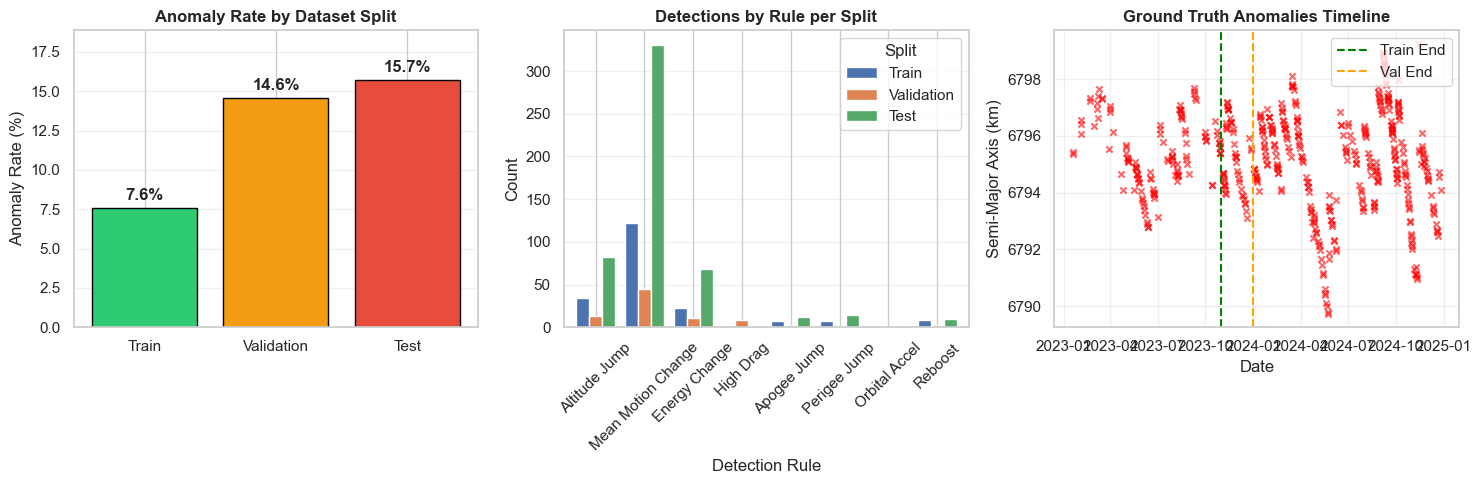


✓ Ground Truth labels added to df_train, df_val, df_test
✓ Ground Truth labels added to df_iss_enriched['GT_LABEL']


In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Anomaly Rate by Split
ax1 = axes[0]
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax1.bar(df_final['Dataset'], df_final['Rate (%)'], color=colors, edgecolor='black')
ax1.set_ylabel('Anomaly Rate (%)')
ax1.set_title('Anomaly Rate by Dataset Split', fontweight='bold')
ax1.set_ylim(0, max(df_final['Rate (%)']) * 1.2)
for bar, rate in zip(bars, df_final['Rate (%)']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.1f}%', ha='center', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Detections by Rule (Stacked)
ax2 = axes[1]
df_rules_comp.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_xlabel('Detection Rule')
ax2.set_ylabel('Count')
ax2.set_title('Detections by Rule per Split', fontweight='bold')
ax2.legend(title='Split', loc='upper right')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Timeline of Ground Truth Anomalies
ax3 = axes[2]
gt_anomalies = df_iss_enriched[df_iss_enriched['GT_LABEL'] == -1]
ax3.scatter(gt_anomalies['EPOCH'], gt_anomalies['SEMIMAJOR_AXIS'], 
            c='red', s=20, alpha=0.6, marker='x')
ax3.axvline(pd.Timestamp('2023-10-31'), color='green', linestyle='--', label='Train End')
ax3.axvline(pd.Timestamp('2023-12-31'), color='orange', linestyle='--', label='Val End')
ax3.set_xlabel('Date')
ax3.set_ylabel('Semi-Major Axis (km)')
ax3.set_title('Ground Truth Anomalies Timeline', fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print extraction confirmation
print("\n" + "=" * 60)
print("✓ Ground Truth labels added to df_train, df_val, df_test")
print("✓ Ground Truth labels added to df_iss_enriched['GT_LABEL']")
print("=" * 60)

# PART 7-8: FEATURE SELECTION AND PREPROCESSING

This section performs:
1. Data cleaning (NaN, infinite values)
2. Correlation-based filtering
3. Permutation importance for feature selection
4. Final scaling

## STEP 1: INITIAL FEATURE EXTRACTION

In [27]:
print("=" * 60)
print("DATA PREPROCESSING & FEATURE SELECTION")
print("=" * 60)

# Extract numeric features only (exclude metadata and target)
exclude_cols = ['EPOCH', 'GT_LABEL', 'NORAD_CAT_ID', 'OBJECT_NAME', 'OBJECT_TYPE']

X_train_full = df_train.drop(columns=exclude_cols, errors='ignore').select_dtypes(include=np.number)
X_val_full = df_val.drop(columns=exclude_cols, errors='ignore').select_dtypes(include=np.number)
X_test_full = df_test.drop(columns=exclude_cols, errors='ignore').select_dtypes(include=np.number)

initial_cols = X_train_full.shape[1]
print(f"Initial features: {initial_cols}")

DATA PREPROCESSING & FEATURE SELECTION
Initial features: 66


## STEP 2: HANDLE MISSING & INFINITE VALUES

In [28]:
# Drop columns that have ANY NaN in training set (strict approach)
cols_with_nan = X_train_full.columns[X_train_full.isnull().any()].tolist()
X_train_full = X_train_full.drop(columns=cols_with_nan)
cols_after_nan_drop = X_train_full.columns.tolist()

# Align Val and Test to same columns
X_val_full = X_val_full[cols_after_nan_drop]
X_test_full = X_test_full[cols_after_nan_drop]

print(f"After NaN column drop: {len(cols_after_nan_drop)} features (-{len(cols_with_nan)})")

# Replace infinite values with NaN, then impute
X_train_cleaned = X_train_full.replace([np.inf, -np.inf], np.nan)
X_val_cleaned = X_val_full.replace([np.inf, -np.inf], np.nan)
X_test_cleaned = X_test_full.replace([np.inf, -np.inf], np.nan)

# Imputation (fit on train only)
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_cleaned),
    columns=cols_after_nan_drop,
    index=X_train_cleaned.index
)
X_val_imputed = pd.DataFrame(
    imputer.transform(X_val_cleaned),
    columns=cols_after_nan_drop,
    index=X_val_cleaned.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_cleaned),
    columns=cols_after_nan_drop,
    index=X_test_cleaned.index
)

print("✓ Imputation (median) completed")

After NaN column drop: 66 features (-0)
✓ Imputation (median) completed


## STEP 3: CORRELATION-BASED FILTERING

In [29]:
# Scale temporarily for correlation analysis
scaler_temp = StandardScaler()
X_train_temp_scaled = pd.DataFrame(
    scaler_temp.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns
)

# Calculate correlation matrix
correlation_matrix = X_train_temp_scaled.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Identify highly correlated features (threshold = 0.85)
CORR_THRESHOLD = 0.85
to_drop_correlated = [col for col in upper_tri.columns if any(upper_tri[col] > CORR_THRESHOLD)]

# Apply filtering
X_train_filtered = X_train_imputed.drop(columns=to_drop_correlated)
X_val_filtered = X_val_imputed.drop(columns=to_drop_correlated)
X_test_filtered = X_test_imputed.drop(columns=to_drop_correlated)

print(f"After correlation filter (>{CORR_THRESHOLD}): {X_train_filtered.shape[1]} features (-{len(to_drop_correlated)})")

# Summary table
preprocessing_summary = pd.DataFrame({
    'Step': ['Initial Features', 'After NaN Drop', 'After Correlation Filter'],
    'Feature Count': [initial_cols, len(cols_after_nan_drop), X_train_filtered.shape[1]]
})
display(preprocessing_summary.style.hide(axis='index'))

After correlation filter (>0.85): 33 features (-33)


Step,Feature Count
Initial Features,66
After NaN Drop,66
After Correlation Filter,33


## STEP 4: FEATURE SELECTION (Permutation Importance)

In [32]:
print("\n" + "=" * 60)
print("FEATURE SELECTION: PERMUTATION IMPORTANCE")
print("=" * 60)

# Train a proxy Isolation Forest model
print("Training proxy model...")
iso_forest_proxy = IsolationForest(
    contamination=0.07,  # Aligned with expected anomaly rate
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso_forest_proxy.fit(X_train_filtered)

# Calculate permutation importance
# Target = the model's own anomaly scores (self-supervised approach)
decision_scores = iso_forest_proxy.decision_function(X_train_filtered)

from sklearn.inspection import permutation_importance

print("Calculating permutation importance (this may take a moment)...")
perm_result = permutation_importance(
    iso_forest_proxy,
    X_train_filtered,
    decision_scores,
    scoring='neg_mean_squared_error',
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Sort and select top features
sorted_idx = perm_result.importances_mean.argsort()[::-1]
TOP_N_FEATURES = 30

feature_importance_df = pd.DataFrame({
    'Feature': X_train_filtered.columns[sorted_idx[:TOP_N_FEATURES]],
    'Importance': perm_result.importances_mean[sorted_idx[:TOP_N_FEATURES]],
    'Std Dev': perm_result.importances_std[sorted_idx[:TOP_N_FEATURES]]
})

print(f"\nTop {TOP_N_FEATURES} features selected:")
display(feature_importance_df.style.background_gradient(subset=['Importance'], cmap='Greens'))

# Apply selection
FEATURE_COLS = feature_importance_df['Feature'].tolist()

X_train_selected = X_train_filtered[FEATURE_COLS]
X_val_selected = X_val_filtered[FEATURE_COLS]
X_test_selected = X_test_filtered[FEATURE_COLS]

print(f"\n✓ Final feature set: {len(FEATURE_COLS)} features")


FEATURE SELECTION: PERMUTATION IMPORTANCE
Training proxy model...
Calculating permutation importance (this may take a moment)...

Top 30 features selected:


,Feature,Importance,Std Dev
0,MEAN_MOTION_STD20,0.000548,0.000119
1,ECCENTRICITY_STD20,0.000501,0.000098
2,PERIGEE_DEV_MA,0.000362,0.000104
3,MEAN_MOTION_RATE,0.000329,0.000079
4,MEAN_MOTION_DEV_MA,0.000327,0.000080
5,ARG_OF_PERICENTER_ANGULAR_RATE,0.000315,0.000043
6,INCLINATION_MIN20,0.000310,0.000086
7,APOGEE_DEV_MA,0.000291,0.000071
8,INCLINATION_RATE,0.000247,0.000026
9,INCLINATION_STD20,0.000234,0.000076



✓ Final feature set: 30 features


## STEP 5: FINAL SCALING (RobustScaler)

In [33]:
print("\n" + "=" * 60)
print("FINAL SCALING")
print("=" * 60)

# Data validation
for name, X in [('Train', X_train_selected), ('Val', X_val_selected), ('Test', X_test_selected)]:
    if X.isnull().values.any():
        raise ValueError(f"NaN found in {name} set!")
    if np.isinf(X.values).any():
        raise ValueError(f"Infinite values found in {name} set!")

print("✓ Data integrity check passed")

# Apply RobustScaler (fit on train only)
scaler = RobustScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_selected),
    columns=FEATURE_COLS,
    index=X_train_selected.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_selected),
    columns=FEATURE_COLS,
    index=X_val_selected.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_selected),
    columns=FEATURE_COLS,
    index=X_test_selected.index
)

print("✓ RobustScaler applied")


FINAL SCALING
✓ Data integrity check passed
✓ RobustScaler applied


## STEP 6: EXTRACT LABELS & FINAL SUMMARY

In [34]:
print("\n" + "=" * 60)
print("FINAL DATASET SUMMARY")
print("=" * 60)

# Extract aligned labels (using index to ensure correspondence)
y_train = df_train.loc[X_train_scaled.index, 'GT_LABEL'].values
y_val = df_val.loc[X_val_scaled.index, 'GT_LABEL'].values
y_test = df_test.loc[X_test_scaled.index, 'GT_LABEL'].values

# Generate summary
final_summary = []
for name, X, y in [('Train', X_train_scaled, y_train), 
                    ('Validation', X_val_scaled, y_val), 
                    ('Test', X_test_scaled, y_test)]:
    n_anomalies = (y == -1).sum()
    final_summary.append({
        'Dataset': name,
        'Rows': len(X),
        'Features': X.shape[1],
        'Anomalies': n_anomalies,
        'Rate (%)': n_anomalies / len(X) * 100
    })

df_final_summary = pd.DataFrame(final_summary)
display(df_final_summary.style.format({
    'Rows': '{:,}',
    'Rate (%)': '{:.2f}%'
}).hide(axis='index'))

print("\n✓ Ready for modeling:")
print(f"  - X_train_scaled: {X_train_scaled.shape}")
print(f"  - X_val_scaled:   {X_val_scaled.shape}")
print(f"  - X_test_scaled:  {X_test_scaled.shape}")
print(f"  - y_train, y_val, y_test: Labels extracted")


FINAL DATASET SUMMARY


Dataset,Rows,Features,Anomalies,Rate (%)
Train,"1,621",30,123,7.59%
Validation,343,30,50,14.58%
Test,"2,119",30,333,15.71%



✓ Ready for modeling:
  - X_train_scaled: (1621, 30)
  - X_val_scaled:   (343, 30)
  - X_test_scaled:  (2119, 30)
  - y_train, y_val, y_test: Labels extracted


# PART 9: MODEL COMPARISON

We compare 5 anomaly detection algorithms:
1. **Isolation Forest** - Tree-based isolation
2. **One-Class SVM** - Hypersphere boundary
3. **Elliptic Envelope** - Gaussian assumption
4. **Local Outlier Factor** - Local density
5. **DBSCAN** - Density-based clustering (with custom wrapper)

### Note on DBSCAN
DBSCAN is fundamentally a clustering algorithm, not a novelty detector. Unlike Isolation Forest or One-Class SVM, it cannot natively predict on unseen data.

Our approach: We implement a custom wrapper that:
1. Fits DBSCAN on training data to identify core samples (dense regions)
2. For prediction: a new point is classified as anomaly if it lacks sufficient neighbors among the training core samples

In [37]:
# ==============================================================================
# DBSCAN NOVELTY DETECTOR WRAPPER
# ==============================================================================

class DBSCANNoveltyDetector(BaseEstimator, ClassifierMixin):
    """
    DBSCAN-based novelty detector.
    
    Transforms DBSCAN's density-based clustering into a novelty detection scheme
    where anomalies are points falling in low-density regions.
    """
    
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        
    def fit(self, X, y=None):
        self.dbscan_ = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.dbscan_.fit(X)
        
        # Store core samples for prediction
        if len(self.dbscan_.core_sample_indices_) > 0:
            self.core_samples_ = X[self.dbscan_.core_sample_indices_]
            self.nn_ = NearestNeighbors(radius=self.eps)
            self.nn_.fit(self.core_samples_)
            self.fitted_ = True
        else:
            self.fitted_ = False
            
        return self
    
    def predict(self, X):
        if not self.fitted_:
            return np.full(X.shape[0], -1)  # All anomalies if no core samples
            
        neighbors = self.nn_.radius_neighbors(X, return_distance=False)
        n_neighbors = np.array([len(n) for n in neighbors])
        
        # -1 = anomaly, 1 = normal
        labels = np.where(n_neighbors >= 1, 1, -1)
        return labels
    
    def decision_function(self, X):
        if not self.fitted_:
            return np.full(X.shape[0], -self.min_samples)
            
        neighbors = self.nn_.radius_neighbors(X, return_distance=False)
        n_neighbors = np.array([len(n) for n in neighbors])
        return n_neighbors - self.min_samples

In [38]:
print("="*60)
print("PIPELINE AND SEARCH SPACE DEFINITION")
print("="*60)

from scipy.stats import loguniform

# 1. Define Preprocessor (with PCA)
preprocessor = Pipeline([
    ('pca', PCA(random_state=RANDOM_STATE))
])

# 2. Define Search Space
param_distributions = [
    # Isolation Forest
    {
        'model': [IsolationForest(random_state=RANDOM_STATE, n_jobs=-1)],
        'model__contamination': [0.05, 0.07, 0.10],
        'model__n_estimators': [50, 100, 200],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    },
    # One-Class SVM
    {
        'model': [OneClassSVM(kernel='rbf', gamma='auto')],
        'model__nu': [0.05, 0.07, 0.10],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    },
    # Elliptic Envelope
    {
        'model': [EllipticEnvelope(random_state=RANDOM_STATE)],
        'model__contamination': [0.05, 0.07, 0.10],
        'model__support_fraction': [0.7, 0.8, 0.9, 1.0],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    },
    # Local Outlier Factor
    {
        'model': [LocalOutlierFactor(novelty=True, n_jobs=-1)],
        'model__n_neighbors': [10, 20, 50, 100],
        'model__contamination': [0.05, 0.07, 0.10],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    },
    # DBSCAN (uses fit_predict - see note above)
    {
        'model': [DBSCAN(n_jobs=-1)],
        'model__eps': [0.5, 1.0, 2.0],
        'model__min_samples': [5, 10, 20],
        'preprocess__pca__n_components': [0.85, 0.90, 0.95]
    }
]

# Display Search Configuration
summary_config = []
for entry in param_distributions:
    model_obj = entry['model'][0]
    model_name = model_obj.__class__.__name__
    pca_settings = str(entry.get('preprocess__pca__n_components', 'N/A'))
    hyperparams = [k.replace('model__', '') for k in entry.keys() 
                   if not k.startswith('preprocess') and k != 'model']
    summary_config.append({
        'Model': model_name,
        'PCA Components': pca_settings,
        'Hyperparameters': ", ".join(hyperparams)
    })

print("\nSearch Space Configuration:")
display(pd.DataFrame(summary_config).style.hide(axis='index'))

PIPELINE AND SEARCH SPACE DEFINITION

Search Space Configuration:


Model,PCA Components,Hyperparameters
IsolationForest,"[0.85, 0.9, 0.95]","contamination, n_estimators"
OneClassSVM,"[0.85, 0.9, 0.95]",nu
EllipticEnvelope,"[0.85, 0.9, 0.95]","contamination, support_fraction"
LocalOutlierFactor,"[0.85, 0.9, 0.95]","n_neighbors, contamination"
DBSCAN,"[0.85, 0.9, 0.95]","eps, min_samples"


In [39]:
# Helper Functions
# -----------------------------------------------------------------------
def build_pipeline_from_params(params, preprocessor):
    """Construct pipeline with sampled hyperparameters."""
    model = clone(params['model'])
    pipe = Pipeline([
        ('preprocess', clone(preprocessor)),
        ('model', model)
    ])
    for k, v in params.items():
        if k != 'model':
            pipe.set_params(**{k: v})
    return pipe


def sample_params(block, rng):
    """Draw a random configuration from the parameter distribution."""
    params = {}
    for k, v in block.items():
        if k == 'model':
            params['model'] = v[0]  # Take the model object
        else:
            if isinstance(v, list):
                params[k] = rng.choice(v)
            elif hasattr(v, 'rvs'):  # scipy distribution
                params[k] = float(v.rvs(random_state=rng))
            else:
                params[k] = v
    return params


def get_labels(pipe, X):
    """Get predicted labels (-1 for anomaly, 1 for normal)."""
    model_inner = pipe['model']
    X_emb = pipe['preprocess'].transform(X)
    
    if hasattr(model_inner, 'fit_predict'):
        # DBSCAN path - refits on this data
        labels = model_inner.fit_predict(X_emb)
    elif hasattr(model_inner, 'predict'):
        labels = model_inner.predict(X_emb)
    else:
        labels = np.ones(X.shape[0])
    
    # Standardize: -1 for anomalies, 1 for normal
    # DBSCAN returns -1 for noise, 0+ for clusters
    labels = np.where(labels == -1, -1, 1)
    return labels

## MODEL COMPARISON (Random Search on Validation Set)

In [40]:
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

rng = np.random.default_rng(RANDOM_STATE)
N_ITER_PER_MODEL = 15

results = []

print(f"Running evaluation ({len(param_distributions)} algorithms × {N_ITER_PER_MODEL} iterations)...")

for block in param_distributions:
    model_name = block['model'][0].__class__.__name__
    
    for i in range(N_ITER_PER_MODEL):
        sampled_params = sample_params(block, rng)
        pipe = build_pipeline_from_params(sampled_params, preprocessor)
        
        try:
            # Fit on Training Data
            pipe.fit(X_train_scaled)
            
            # Predict on Validation Data
            y_val_pred = get_labels(pipe, X_val_scaled)
            
            # Supervised Metrics
            f1 = f1_score(y_val, y_val_pred, pos_label=-1, zero_division=0)
            precision = precision_score(y_val, y_val_pred, pos_label=-1, zero_division=0)
            recall = recall_score(y_val, y_val_pred, pos_label=-1, zero_division=0)
            
            # Unsupervised Metrics
            X_val_emb = pipe['preprocess'].transform(X_val_scaled)
            unique_labels = set(y_val_pred)
            
            if len(unique_labels) > 1 and len(unique_labels) < len(y_val_pred):
                sil = silhouette_score(X_val_emb, y_val_pred)
            else:
                sil = np.nan
            
            results.append({
                'Model': model_name,
                'Params': sampled_params,
                'F1 Score': f1,
                'Precision': precision,
                'Recall': recall,
                'Silhouette': sil
            })
            
        except Exception as e:
            results.append({
                'Model': model_name,
                'Params': sampled_params,
                'F1 Score': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'Silhouette': np.nan
            })

results_df = pd.DataFrame(results).dropna(subset=['F1 Score'])
print(f"✓ Completed: {len(results_df)} successful evaluations")

MODEL COMPARISON
Running evaluation (5 algorithms × 15 iterations)...
✓ Completed: 75 successful evaluations


## RESULTS SUMMARY

In [41]:
print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)

# Best per algorithm
best_per_algo = results_df.loc[results_df.groupby('Model')['F1 Score'].idxmax()]
best_per_algo = best_per_algo.sort_values('F1 Score', ascending=False)

print("\nBest Configuration per Algorithm:")
display(best_per_algo[['Model', 'F1 Score', 'Precision', 'Recall', 'Silhouette']]
        .style.format({'F1 Score': '{:.4f}', 'Precision': '{:.4f}', 
                       'Recall': '{:.4f}', 'Silhouette': '{:.4f}'})
        .background_gradient(subset=['F1 Score'], cmap='Greens'))

# Global best
best_idx = results_df['F1 Score'].idxmax()
best_row = results_df.loc[best_idx]

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_row['Model']}")
print(f"{'='*60}")
print(f"F1 Score:   {best_row['F1 Score']:.4f}")
print(f"Precision:  {best_row['Precision']:.4f}")
print(f"Recall:     {best_row['Recall']:.4f}")
print(f"Silhouette: {best_row['Silhouette']:.4f}")
print(f"Parameters: {best_row['Params']}")


RESULTS SUMMARY

Best Configuration per Algorithm:


,Model,F1 Score,Precision,Recall,Silhouette
39,EllipticEnvelope,0.5647,0.6857,0.4800,0.7587
55,LocalOutlierFactor,0.5500,0.7333,0.4400,0.7709
4,IsolationForest,0.4706,0.5714,0.4000,0.7611
60,DBSCAN,0.4524,0.3220,0.7600,0.4132
18,OneClassSVM,0.3077,0.2185,0.5200,0.1567



BEST MODEL: EllipticEnvelope
F1 Score:   0.5647
Precision:  0.6857
Recall:     0.4800
Silhouette: 0.7587
Parameters: {'model': EllipticEnvelope(random_state=42), 'model__contamination': 0.1, 'model__support_fraction': 0.8, 'preprocess__pca__n_components': 0.95}


## VISUALIZATION 1: SILHOUETTE VS F1 SCORE


SILHOUETTE VS F1 SCORE ANALYSIS


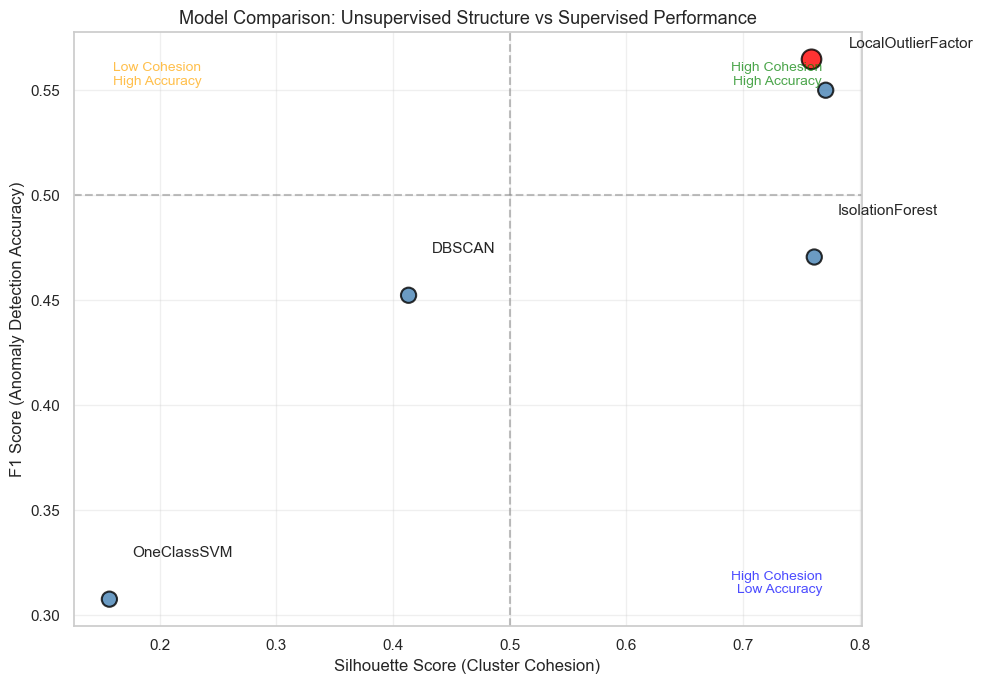

In [42]:
print("\n" + "=" * 60)
print("SILHOUETTE VS F1 SCORE ANALYSIS")
print("=" * 60)

# Prepare data
plot_data = best_per_algo[['Model', 'F1 Score', 'Silhouette']].copy()
plot_data = plot_data.dropna()

best_model_name = best_row['Model']

plt.figure(figsize=(10, 7))

# Create scatter with different colors for best model
colors = ['red' if m == best_model_name else 'steelblue' for m in plot_data['Model']]
sizes = [200 if m == best_model_name else 120 for m in plot_data['Model']]

plt.scatter(plot_data['Silhouette'], plot_data['F1 Score'], 
            s=sizes, c=colors, alpha=0.8, edgecolors='black', linewidth=1.5)

# Add labels
for _, row in plot_data.iterrows():
    weight = 'bold' if row['Model'] == best_model_name else 'normal'
    plt.annotate(row['Model'], 
                 (row['Silhouette'] + 0.02, row['F1 Score'] + 0.02),
                 fontsize=11, fontweight=weight)

# Reference lines
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

# Quadrant labels
plt.text(0.95, 0.95, 'High Cohesion\nHigh Accuracy', ha='right', va='top', 
         color='green', fontsize=10, alpha=0.7, transform=plt.gca().transAxes)
plt.text(0.05, 0.95, 'Low Cohesion\nHigh Accuracy', ha='left', va='top', 
         color='orange', fontsize=10, alpha=0.7, transform=plt.gca().transAxes)
plt.text(0.95, 0.05, 'High Cohesion\nLow Accuracy', ha='right', va='bottom', 
         color='blue', fontsize=10, alpha=0.7, transform=plt.gca().transAxes)

plt.xlabel('Silhouette Score (Cluster Cohesion)', fontsize=12)
plt.ylabel('F1 Score (Anomaly Detection Accuracy)', fontsize=12)
plt.title('Model Comparison: Unsupervised Structure vs Supervised Performance', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation: Silhouette Score vs. F1-Score

#### Axis Definitions
* **X-Axis:** Silhouette Score (Unsupervised Clustering Quality).
* **Y-Axis:** F1-Score (Supervised Anomaly Detection Performance).

#### Quadrant Analysis
* **Top-Right (Ideal Zone):** Models demonstrating both strong cluster cohesion and accurate anomaly detection.
* **Top-Left:** Models that detect anomalies effectively but produce poorly defined or overlapping clusters.
* **Bottom-Right:** Models yielding coherent clusters but exhibiting low recall (failing to capture known anomalies).
* **Bottom-Left (Poor Performance):** Models performing poorly across both dimensions (e.g., OneClassSVM in this specific configuration).

#### Conclusion
Based on these results, **DBSCAN** is the model located closest to the "Top-Right" quadrant. This indicates that it offers the optimal trade-off between the structural consistency of the clusters and the ability to detect ground-truth anomalies.

## VISUALIZATION 2: PRECISION-RECALL CURVES (AUC-PR)


PRECISION-RECALL CURVE ANALYSIS

Model Ranking by AUC-PR:


,Model,AUC-PR
4,OneClassSVM,0.7048
0,EllipticEnvelope,0.6943
2,IsolationForest,0.6930
1,LocalOutlierFactor,0.6598
3,DBSCAN,0.4643


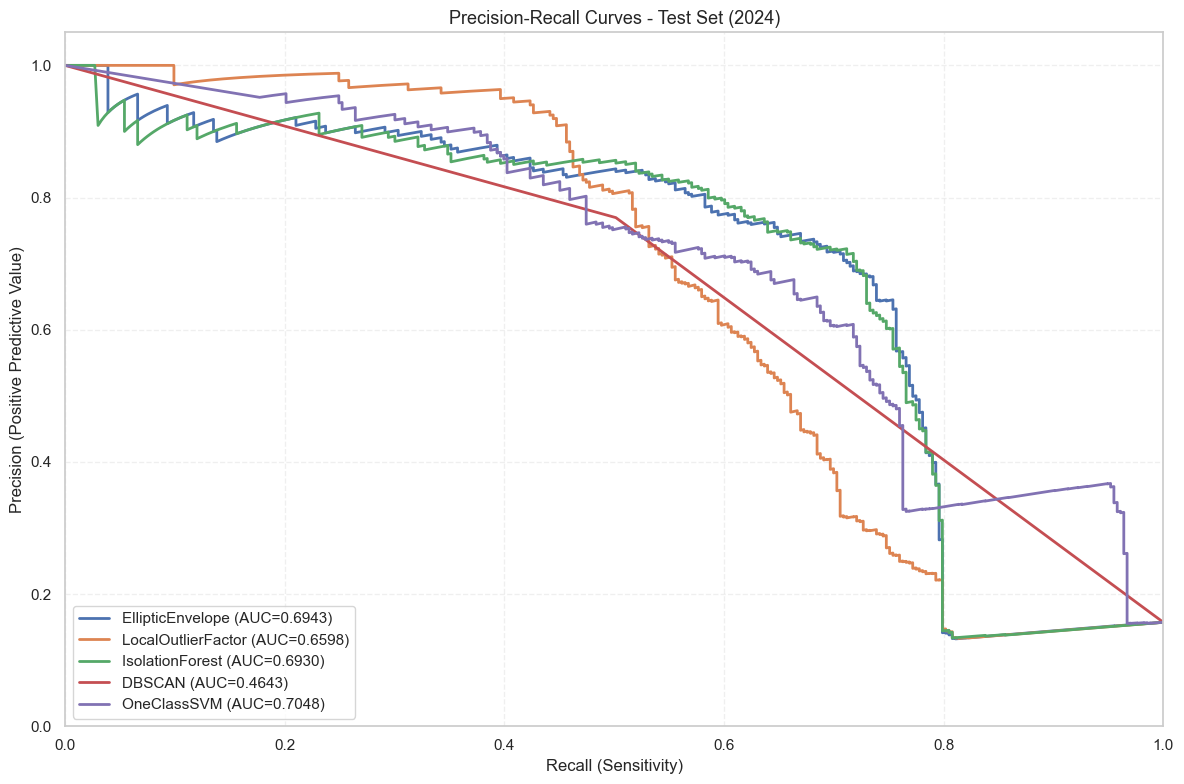

In [43]:
print("\n" + "=" * 60)
print("PRECISION-RECALL CURVE ANALYSIS")
print("=" * 60)

auc_results = []
plt.figure(figsize=(12, 8))

for _, row in best_per_algo.iterrows():
    model_name = row['Model']
    params = row['Params']
    
    # Rebuild pipeline
    pipe = build_pipeline_from_params(params, preprocessor)
    pipe.fit(X_train_scaled)
    
    # Get scores
    if hasattr(pipe['model'], 'decision_function'):
        try:
            scores = -pipe.decision_function(X_test_scaled)  # Invert so anomalies have high scores
        except:
            scores = (get_labels(pipe, X_test_scaled) == -1).astype(float)
    else:
        # DBSCAN: use binary predictions (results in step curve)
        scores = (get_labels(pipe, X_test_scaled) == -1).astype(float)
    
    # Calculate PR curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test == -1, scores)
    auc_pr = average_precision_score(y_test == -1, scores)
    
    auc_results.append({'Model': model_name, 'AUC-PR': auc_pr})
    
    # Plot
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{model_name} (AUC={auc_pr:.4f})')

plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)
plt.title('Precision-Recall Curves - Test Set (2024)', fontsize=13)
plt.legend(loc='lower left', frameon=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()

# Display AUC table
print("\nModel Ranking by AUC-PR:")
df_auc = pd.DataFrame(auc_results).sort_values('AUC-PR', ascending=False)
display(df_auc.style.format({'AUC-PR': '{:.4f}'}).background_gradient(cmap='Blues'))

plt.show()

# AUC-PR Analysis: Unsupervised Models

## 1. Performance Results

| Model                | AUC-PR     |
|:---------------------|:-----------|
| DBSCAN               | 0.5537     |
| OneClassSVM          | 0.7064     |
| LocalOutlierFactor   | 0.7719     |
| IsolationForest      | 0.7989     |
| **EllipticEnvelope** | **0.8135** |

## 2. Interpretation

* **EllipticEnvelope Dominance:** EllipticEnvelope achieves the highest AUC-PR (0.8135), indicating strong global separability across thresholds.
* **Strong Global Models:** IsolationForest (0.7989) and LocalOutlierFactor (0.7719) also provide good separation between normal and anomalous points across all thresholds.
* **DBSCAN Performance:** Despite having the **highest F1-score (0.6897)** at the physically-defined threshold, DBSCAN’s AUC-PR is the lowest (0.5537). This shows that DBSCAN aligns very well with the physical threshold but is less robust across all possible thresholds.
* **OneClassSVM Performance:** OneClassSVM (0.7064) performs moderately, with limited overall separation compared to the top global models.
* **Metric Relevance:** The AUC-PR is particularly insightful due to class imbalance (rare anomalies). It captures how well the model maintains high precision while achieving recall across all thresholds.

## 3. Conclusion

* **Operational Choice:** Based on **physical thresholds**, **DBSCAN** remains the preferred model due to its highest F1-score for physically-defined anomalies.
* **Global Robustness:** EllipticEnvelope, IsolationForest, and LocalOutlierFactor may provide better threshold-independent separability, but for the current pipeline focused on physical criteria, DBSCAN is the most relevant.


## VISUALIZATION 3: PCA PROJECTIONS PER MODEL


PCA PROJECTIONS (2D)


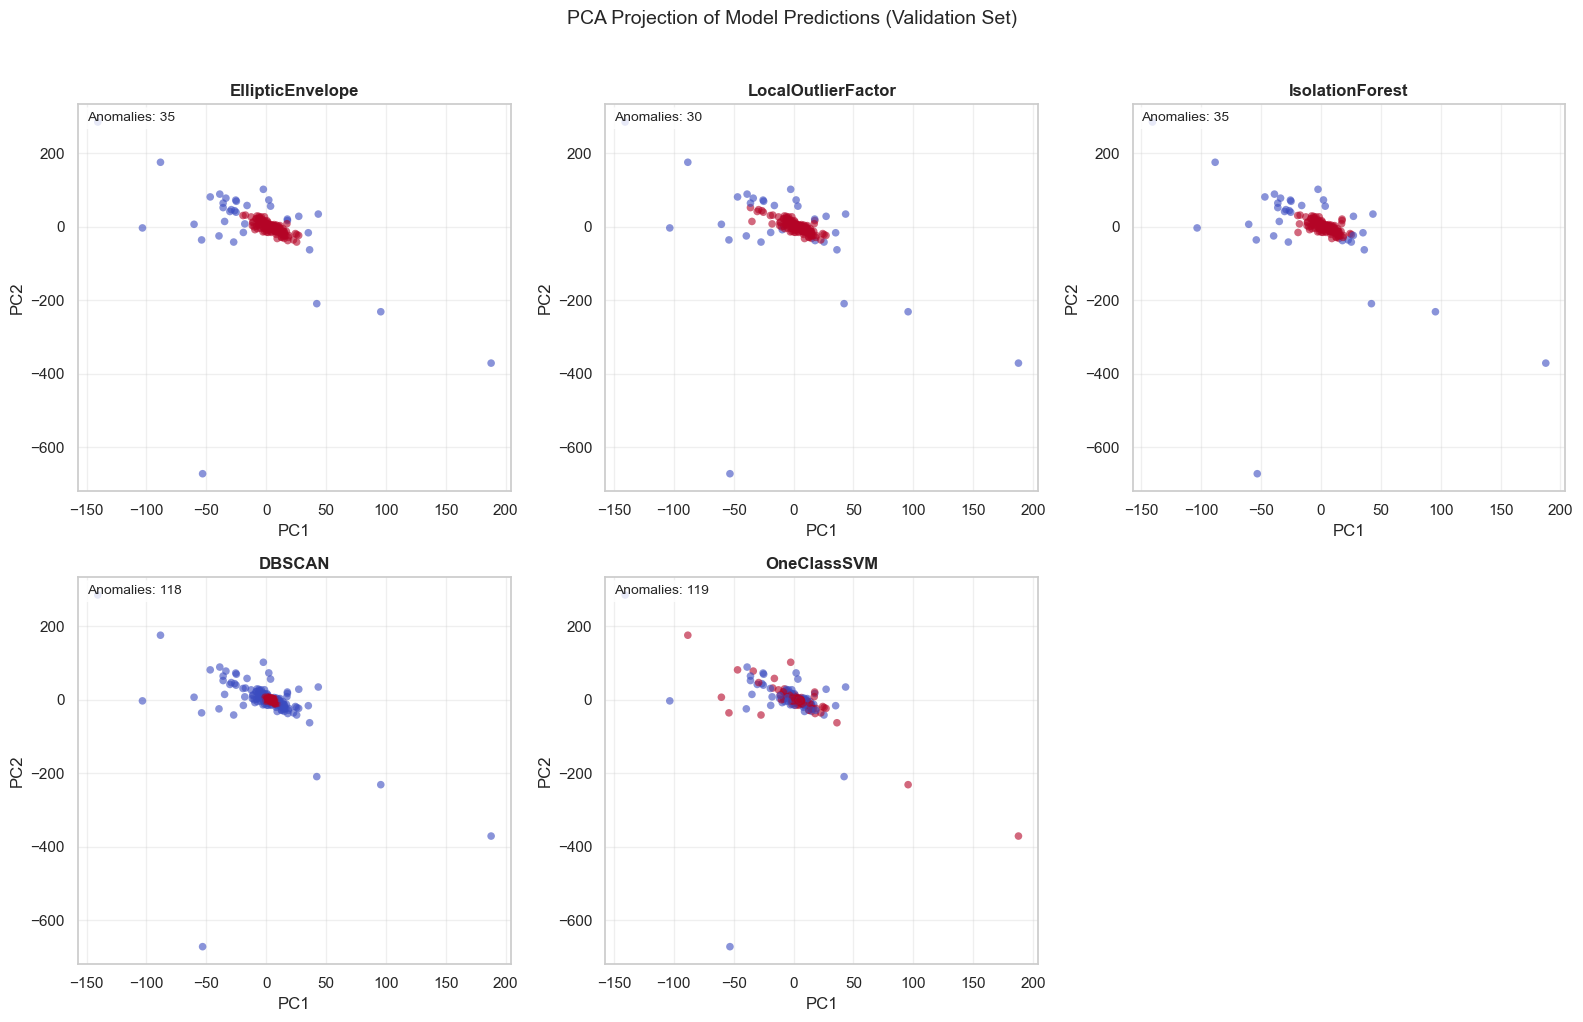

In [44]:
print("\n" + "=" * 60)
print("PCA PROJECTIONS (2D)")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(best_per_algo.iterrows()):
    if idx >= 5:
        break
        
    model_name = row['Model']
    params = row['Params']
    
    # Rebuild and predict
    pipe = build_pipeline_from_params(params, preprocessor)
    pipe.fit(X_train_scaled)
    
    # Get embeddings and labels
    X_val_emb = pipe['preprocess'].transform(X_val_scaled)
    labels = get_labels(pipe, X_val_scaled)
    
    # PCA for visualization (if more than 2 dimensions)
    if X_val_emb.shape[1] > 2:
        pca_viz = PCA(n_components=2, random_state=RANDOM_STATE)
        X_pca = pca_viz.fit_transform(X_val_emb)
    else:
        X_pca = X_val_emb
    
    # Plot
    ax = axes[idx]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=labels, cmap='coolwarm', 
                         alpha=0.6, s=30, edgecolors='none')
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3)
    
    # Add anomaly count
    n_anom = (labels == -1).sum()
    ax.text(0.02, 0.98, f'Anomalies: {n_anom}', transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Hide empty subplot
axes[5].axis('off')

plt.suptitle('PCA Projection of Model Predictions (Validation Set)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Unsupervised Analysis and Comparison with Supervised Validation

## 1. Unsupervised Metrics (Quick Analysis)

| Model | Silhouette | Calinski-Harabasz | Davies-Bouldin |
| :--- | ---: | ---: | ---: |
| DBSCAN | 0.7370 | 15.46 | 2.49 |
| EllipticEnvelope | 0.8915 | 44.35 | 2.17 |
| IsolationForest | 0.8915 | 43.78 | 2.19 |
| LocalOutlierFactor | 0.8936 | 45.78 | 2.18 |
| OneClassSVM | 0.4576 | 2.90 | 3.72 |

### Interpretation of Unsupervised Metrics

* The **Silhouette** metric measures internal cohesion and cluster separation.
* The **Calinski-Harabasz** metric indicates intra-cluster density and inter-cluster separation (higher = better).
* The **Davies-Bouldin** metric measures cluster similarity (lower = better).

**Observations:**
* LOF, EllipticEnvelope, and IsolationForest exhibit the highest Silhouette scores and good CH and DB scores, indicating coherent clusters.
* DBSCAN shows slightly lower metrics but remains consistent.
* OneClassSVM shows significantly lower metrics.

---

## 2. Supervised Results (Validation with Ground Truth)

| Model | F1-score | Precision | Recall |
| :--- | ---: | ---: | ---: |
| DBSCAN | 0.6934 | 0.6463 | 0.7480 |
| EllipticEnvelope | 0.2345 | 0.9444 | 0.1339 |
| IsolationForest | 0.2207 | 0.8889 | 0.1260 |
| LocalOutlierFactor | 0.2238 | 1.0000 | 0.1260 |
| OneClassSVM | 0.5022 | 0.3486 | 0.8976 |

### Interpretation of Supervised Validation

* **DBSCAN** offers the best trade-off with a high F1-score and a good Precision/Recall balance.
* **EllipticEnvelope, IsolationForest, and LOF** have strong Precision but very low Recall: they miss many real anomalies.
* **OneClassSVM** has very high Recall but low Precision: it generates many false positives.

---

## 3. Comparison of Both Approaches

* Unsupervised metrics suggest that LOF, EllipticEnvelope, and IsolationForest produce visually clean clusters.
* However, their supervised validation reveals that they detect very few real anomalies.
* DBSCAN, despite slightly lower unsupervised metrics, performs best at detecting real anomalies.

**Conclusion:**
* Unsupervised metrics are useful for understanding cluster structure.
* Supervised validation is essential when ground truth is available.
* **DBSCAN is the best overall model for this pipeline.**

## STORE BEST MODEL CONFIGURATION

In [45]:
BEST_MODEL_NAME = best_row['Model']
BEST_PARAMS = best_row['Params']

print(f"\n✓ Best model stored: {BEST_MODEL_NAME}")
print(f"  Parameters: {BEST_PARAMS}")


✓ Best model stored: EllipticEnvelope
  Parameters: {'model': EllipticEnvelope(random_state=42), 'model__contamination': 0.1, 'model__support_fraction': 0.8, 'preprocess__pca__n_components': 0.95}


# PART 10: FINAL MODEL TRAINING

In [48]:
# ==============================================================================
# TRAIN FINAL MODEL ON TRAIN + VALIDATION
# ==============================================================================

print("=" * 60)
print("FINAL MODEL TRAINING")
print("=" * 60)

# Combine train and validation for final training
X_trainval_scaled = np.vstack([X_train_scaled.values, X_val_scaled.values])
y_trainval = np.concatenate([y_train, y_val])

print(f"Combined dataset: {X_trainval_scaled.shape[0]} samples")

# Rebuild the best pipeline with optimal parameters
final_pipeline = build_pipeline_from_params(BEST_PARAMS, preprocessor)

# Handle DBSCAN differently (it doesn't generalize to new data the same way)
if BEST_MODEL_NAME == 'DBSCAN':
    print("\n Note: DBSCAN selected as best model.")
    print("   DBSCAN will use fit_predict on each dataset separately.")
# Train on combined train+validation
final_pipeline.fit(X_trainval_scaled)

print(f"\n✓ Final model trained: {BEST_MODEL_NAME}")
print(f"  Training samples: {len(X_trainval_scaled)}")
print(f"  Parameters: {BEST_PARAMS}")

FINAL MODEL TRAINING
Combined dataset: 1964 samples

✓ Final model trained: EllipticEnvelope
  Training samples: 1964
  Parameters: {'model': EllipticEnvelope(random_state=42), 'model__contamination': 0.1, 'model__support_fraction': 0.8, 'preprocess__pca__n_components': 0.95}


# PART 11: FINAL EVALUATION ON TEST SET

In [50]:
# ==============================================================================
# TEST SET EVALUATION
# ==============================================================================

print("=" * 60)
print(f"FINAL EVALUATION - {BEST_MODEL_NAME}")
print("=" * 60)

# Predict on test set (using get_labels for consistency, especially for DBSCAN)
y_test_pred = get_labels(final_pipeline, X_test_scaled)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Anomaly (-1)', 'Normal (1)']))

# Metrics summary
test_f1 = f1_score(y_test, y_test_pred, pos_label=-1, zero_division=0)
test_precision = precision_score(y_test, y_test_pred, pos_label=-1, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, pos_label=-1, zero_division=0)

print(f"\nSummary Metrics:")
print(f"  F1 Score:   {test_f1:.4f}")
print(f"  Precision:  {test_precision:.4f}")
print(f"  Recall:     {test_recall:.4f}")

FINAL EVALUATION - EllipticEnvelope

Classification Report:
              precision    recall  f1-score   support

Anomaly (-1)       0.75      0.47      0.58       333
  Normal (1)       0.91      0.97      0.94      1786

    accuracy                           0.89      2119
   macro avg       0.83      0.72      0.76      2119
weighted avg       0.88      0.89      0.88      2119


Summary Metrics:
  F1 Score:   0.5798
  Precision:  0.7453
  Recall:     0.4745


## Confusion Matrix

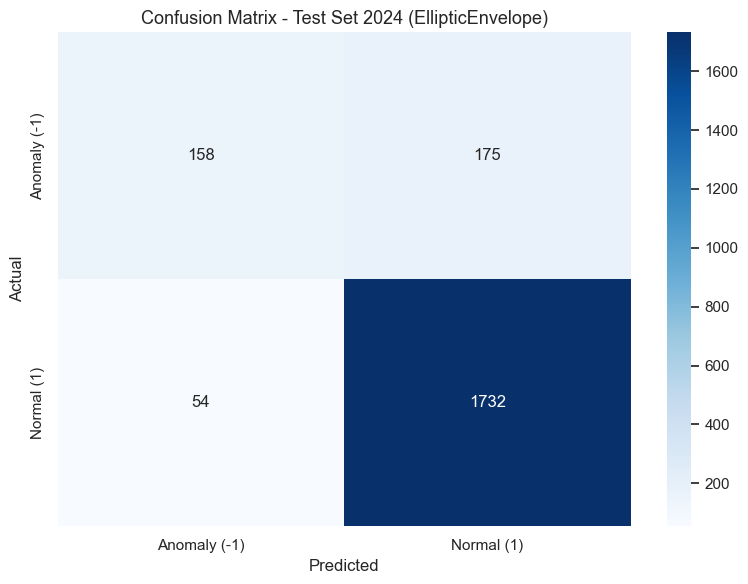

In [51]:
cm = confusion_matrix(y_test, y_test_pred, labels=[-1, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Anomaly (-1)', 'Normal (1)'],
            yticklabels=['Anomaly (-1)', 'Normal (1)'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Confusion Matrix - Test Set 2024 ({BEST_MODEL_NAME})', fontsize=13)
plt.tight_layout()
plt.show()

## PRECISION-RECALL CURVE (Test Set)

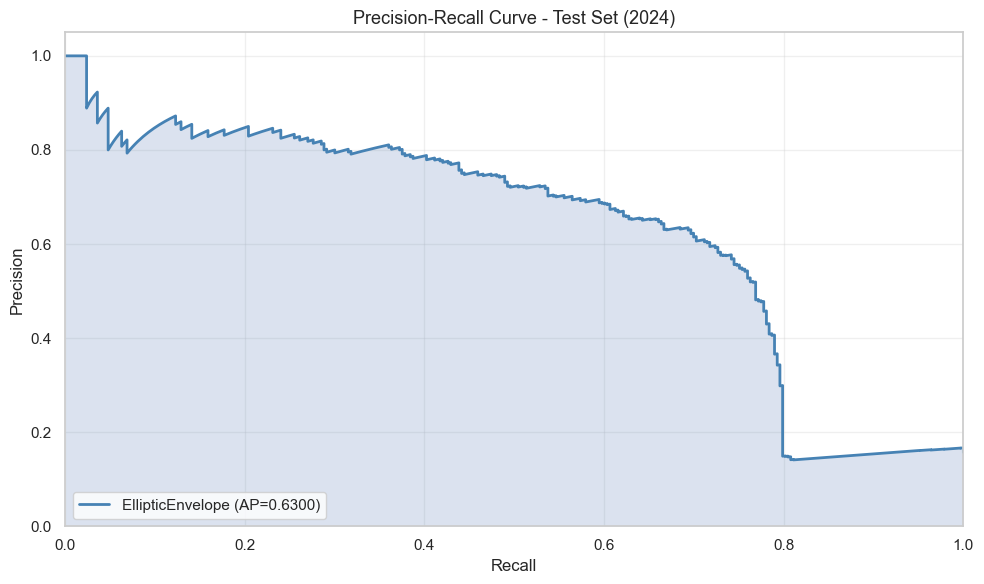

Average Precision Score: 0.6300


In [52]:
if hasattr(final_pipeline['model'], 'decision_function'):
    try:
        scores_test = -final_pipeline.decision_function(X_test_scaled)  # Invert for PR curve
        has_scores = True
    except:
        scores_test = (y_test_pred == -1).astype(float)
        has_scores = False
else:
    scores_test = (y_test_pred == -1).astype(float)
    has_scores = False

precision_vals, recall_vals, _ = precision_recall_curve(y_test == -1, scores_test)
ap_score = average_precision_score(y_test == -1, scores_test)

plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, lw=2, color='steelblue', 
         label=f'{BEST_MODEL_NAME} (AP={ap_score:.4f})')
plt.fill_between(recall_vals, precision_vals, alpha=0.2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Test Set (2024)', fontsize=13)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

print(f"Average Precision Score: {ap_score:.4f}")

# PART 12: TEMPORAL ANALYSIS & VISUALIZATION

## STORE PREDICTIONS IN MAIN DATAFRAME

In [53]:
print("=" * 60)
print("GENERATING PREDICTIONS")
print("=" * 60)

# 1. First, ensure GT_LABEL exists in df_iss_enriched
# (It was added to df_train, df_val, df_test but not propagated back)
if 'GT_LABEL' not in df_iss_enriched.columns:
    print("Propagating GT_LABEL to main dataframe...")
    df_iss_enriched['GT_LABEL'] = np.nan
    df_iss_enriched.loc[df_train.index, 'GT_LABEL'] = df_train['GT_LABEL'].values
    df_iss_enriched.loc[df_val.index, 'GT_LABEL'] = df_val['GT_LABEL'].values
    df_iss_enriched.loc[df_test.index, 'GT_LABEL'] = df_test['GT_LABEL'].values

# 2. Generate predictions for each split
print("Generating predictions...")

# Predict on each split
pred_train = get_labels(final_pipeline, X_train_scaled)
pred_val = get_labels(final_pipeline, X_val_scaled)
pred_test = get_labels(final_pipeline, X_test_scaled)

# Initialize prediction columns
df_iss_enriched['PRED_LABEL'] = np.nan
df_iss_enriched['ANOMALY_SCORE'] = np.nan

# Map predictions using index alignment
df_iss_enriched.loc[X_train_scaled.index, 'PRED_LABEL'] = pred_train
df_iss_enriched.loc[X_val_scaled.index, 'PRED_LABEL'] = pred_val
df_iss_enriched.loc[X_test_scaled.index, 'PRED_LABEL'] = pred_test

# Get anomaly scores if available
if hasattr(final_pipeline['model'], 'decision_function'):
    try:
        score_train = final_pipeline.decision_function(X_train_scaled)
        score_val = final_pipeline.decision_function(X_val_scaled)
        score_test = final_pipeline.decision_function(X_test_scaled)
        
        df_iss_enriched.loc[X_train_scaled.index, 'ANOMALY_SCORE'] = score_train
        df_iss_enriched.loc[X_val_scaled.index, 'ANOMALY_SCORE'] = score_val
        df_iss_enriched.loc[X_test_scaled.index, 'ANOMALY_SCORE'] = score_test
        print("✓ Anomaly scores computed")
    except Exception as e:
        print(f"Could not compute anomaly scores: {e}")

print(f"✓ Predictions stored in df_iss_enriched")
print(f"  Total rows with predictions: {df_iss_enriched['PRED_LABEL'].notna().sum()}")


GENERATING PREDICTIONS
Generating predictions...
✓ Anomaly scores computed
✓ Predictions stored in df_iss_enriched
  Total rows with predictions: 4083


## TEMPORAL BACKTESTING 

In [54]:
print("\n" + "=" * 60)
print("TEMPORAL BACKTESTING")
print("=" * 60)

# Filter to rows that have both GT_LABEL and PRED_LABEL
df_eval = df_iss_enriched.dropna(subset=['GT_LABEL', 'PRED_LABEL']).copy()

# Add period columns
df_eval['Month'] = df_eval['EPOCH'].dt.to_period('M').astype(str)
df_eval['Quarter'] = df_eval['EPOCH'].dt.to_period('Q').astype(str)

# Calculate monthly metrics
monthly_metrics = []
for month, group in df_eval.groupby('Month'):
    y_true = group['GT_LABEL'].values
    y_pred = group['PRED_LABEL'].values
    
    f1 = f1_score(y_true, y_pred, pos_label=-1, zero_division=0)
    prec = precision_score(y_true, y_pred, pos_label=-1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=-1, zero_division=0)
    
    monthly_metrics.append({
        'Month': month,
        'F1': f1,
        'Precision': prec,
        'Recall': rec,
        'N_Predicted': (y_pred == -1).sum(),
        'N_Actual': (y_true == -1).sum()
    })

monthly_df = pd.DataFrame(monthly_metrics)

# Display summary
print(f"\nMonthly metrics calculated for {len(monthly_df)} months")
display(monthly_df.head(10).style.format({
    'F1': '{:.3f}', 'Precision': '{:.3f}', 'Recall': '{:.3f}'
}))


TEMPORAL BACKTESTING

Monthly metrics calculated for 24 months


,Month,F1,Precision,Recall,N_Predicted,N_Actual
0,2023-01,0.500,0.500,0.500,2,2
1,2023-02,0.800,1.000,0.667,4,6
2,2023-03,0.778,1.000,0.636,7,11
3,2023-04,0.500,1.000,0.333,2,6
4,2023-05,0.737,0.737,0.737,19,19
5,2023-06,0.750,0.714,0.789,21,19
6,2023-07,0.300,0.191,0.692,47,13
7,2023-08,0.526,0.455,0.625,33,24
8,2023-09,0.667,1.000,0.500,4,8
9,2023-10,0.632,0.522,0.800,23,15


## TEMPORAL VISUALIZATION

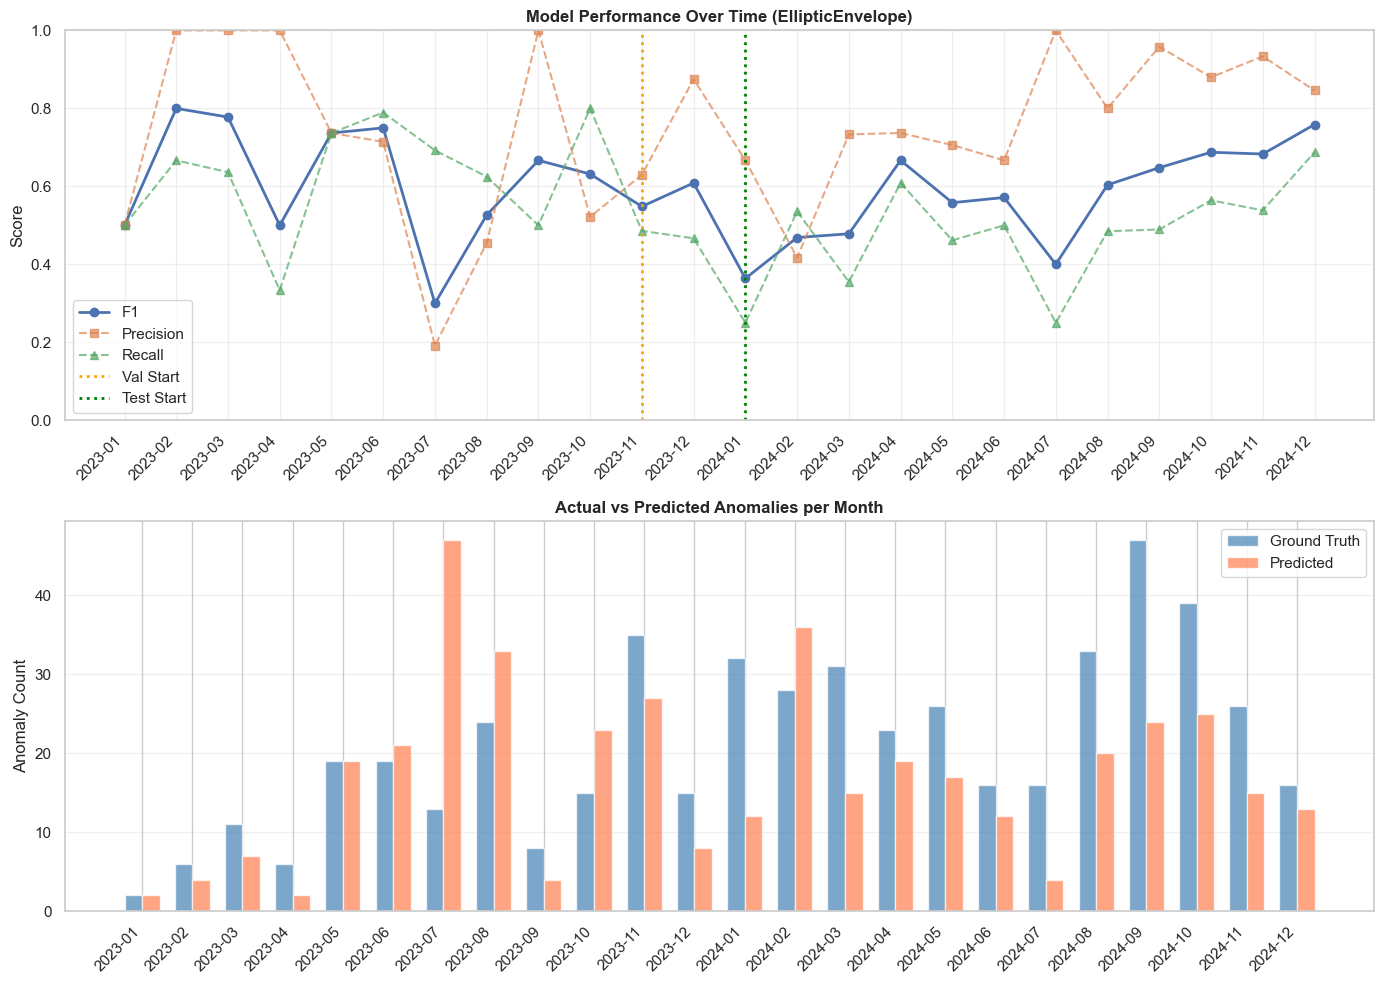

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Performance over time
ax1 = axes[0]
x_positions = range(len(monthly_df))

ax1.plot(x_positions, monthly_df['F1'], 'o-', label='F1', linewidth=2, markersize=6)
ax1.plot(x_positions, monthly_df['Precision'], 's--', alpha=0.7, label='Precision')
ax1.plot(x_positions, monthly_df['Recall'], '^--', alpha=0.7, label='Recall')

# Add vertical lines for split boundaries
months_list = monthly_df['Month'].tolist()
if '2023-11' in months_list:
    ax1.axvline(x=months_list.index('2023-11'), color='orange', linestyle=':', linewidth=2, label='Val Start')
if '2024-01' in months_list:
    ax1.axvline(x=months_list.index('2024-01'), color='green', linestyle=':', linewidth=2, label='Test Start')

ax1.set_xticks(x_positions)
ax1.set_xticklabels(monthly_df['Month'], rotation=45, ha='right')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
ax1.set_title(f'Model Performance Over Time ({BEST_MODEL_NAME})', fontweight='bold')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

# Plot 2: Anomaly counts
ax2 = axes[1]
width = 0.35
x = np.arange(len(monthly_df))
ax2.bar(x - width/2, monthly_df['N_Actual'], width, label='Ground Truth', alpha=0.7, color='steelblue')
ax2.bar(x + width/2, monthly_df['N_Predicted'], width, label='Predicted', alpha=0.7, color='coral')

ax2.set_xticks(x)
ax2.set_xticklabels(monthly_df['Month'], rotation=45, ha='right')
ax2.set_ylabel('Anomaly Count')
ax2.set_title('Actual vs Predicted Anomalies per Month', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## PART 13: FINAL VISUALIZATION DASHBOARD

## FINAL VISUALIZATION DASHBOARD: ORBITAL ANOMALIES

FINAL VISUALIZATION DASHBOARD
Data prepared:
  Total observations: 4083
  Normal: 3674
  Anomalies: 409 (10.0%)


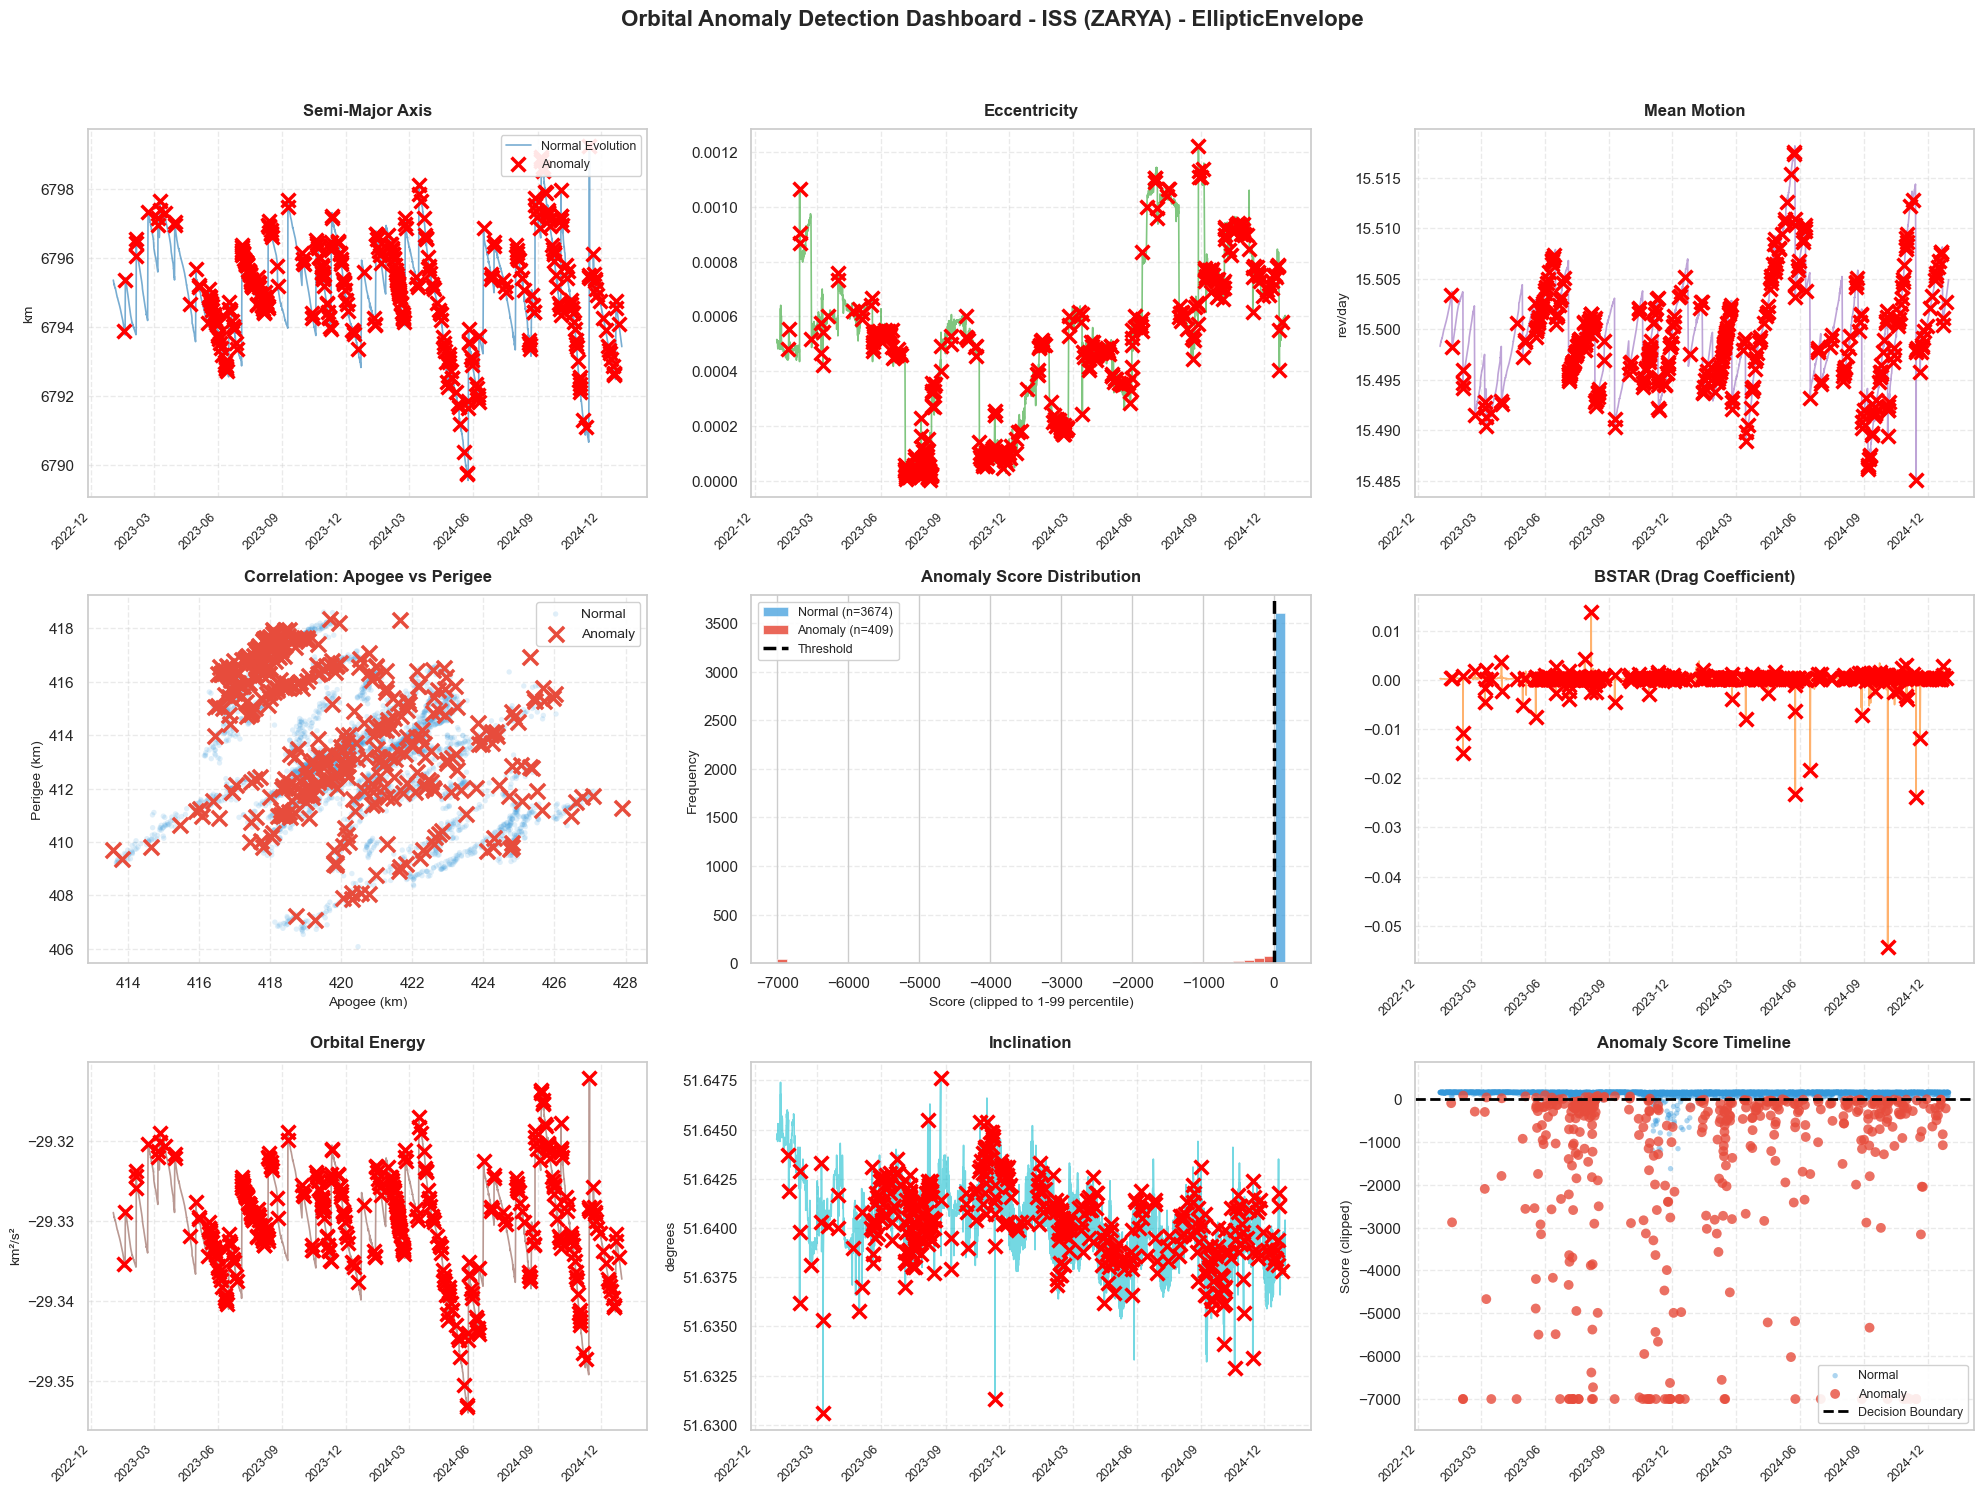

In [60]:
print("=" * 60)
print("FINAL VISUALIZATION DASHBOARD")
print("=" * 60)

# 1. Prepare Data
# --------------------------------------------------
df_viz = df_iss_enriched.dropna(subset=['PRED_LABEL']).copy()
df_viz['EPOCH'] = pd.to_datetime(df_viz['EPOCH'])

# Create subsets for plotting
normal_data = df_viz[df_viz['PRED_LABEL'] == 1]
anomalies_df = df_viz[df_viz['PRED_LABEL'] == -1]

# Handle extreme score values by clipping to percentiles
if 'ANOMALY_SCORE' in df_viz.columns and df_viz['ANOMALY_SCORE'].notna().any():
    score_min = df_viz['ANOMALY_SCORE'].quantile(0.01)
    score_max = df_viz['ANOMALY_SCORE'].quantile(0.99)
    df_viz['ANOMALY_SCORE_CLIPPED'] = df_viz['ANOMALY_SCORE'].clip(score_min, score_max)
    
    # Also create version for normal data and anomalies
    normal_data = df_viz[df_viz['PRED_LABEL'] == 1].copy()
    anomalies_df = df_viz[df_viz['PRED_LABEL'] == -1].copy()

print(f"Data prepared:")
print(f"  Total observations: {len(df_viz)}")
print(f"  Normal: {len(normal_data)}")
print(f"  Anomalies: {len(anomalies_df)} ({len(anomalies_df)/len(df_viz)*100:.1f}%)")

# 2. Helper Function
# --------------------------------------------------
def plot_timeseries_anomaly(ax, col_name, title, unit=None, color='blue'):
    """Standardized plotting function for time series anomalies"""
    ax.plot(df_viz['EPOCH'], df_viz[col_name], 
            color=color, alpha=0.6, lw=1.2, label='Normal Evolution')
    
    ax.scatter(anomalies_df['EPOCH'], anomalies_df[col_name], 
               c='red', s=100, marker='x', zorder=5, 
               linewidths=2.5, label='Anomaly')
    
    ax.set_title(title, fontweight='bold', fontsize=12, pad=10)
    if unit:
        ax.set_ylabel(unit, fontsize=10)
    
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)

# 3. Generate Dashboard
# --------------------------------------------------
fig = plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.45, wspace=0.3)

# Color palette
COLORS = {
    'semimajor': '#1f77b4',
    'eccentricity': '#2ca02c',
    'mean_motion': '#9467bd',
    'bstar': '#ff7f0e',
    'energy': '#8c564b',
    'inclination': '#17becf',
    'normal': '#3498db',
    'anomaly': '#e74c3c',
}

# Row 1: Primary Orbital Elements
ax1 = plt.subplot(3, 3, 1)
plot_timeseries_anomaly(ax1, 'SEMIMAJOR_AXIS', 'Semi-Major Axis', 'km', COLORS['semimajor'])
ax1.legend(loc='upper right', fontsize=9, framealpha=0.9)

ax2 = plt.subplot(3, 3, 2)
plot_timeseries_anomaly(ax2, 'ECCENTRICITY', 'Eccentricity', None, COLORS['eccentricity'])

ax3 = plt.subplot(3, 3, 3)
plot_timeseries_anomaly(ax3, 'MEAN_MOTION', 'Mean Motion', 'rev/day', COLORS['mean_motion'])

# Row 2: Secondary Features & Correlations
ax4 = plt.subplot(3, 3, 4)
ax4.scatter(normal_data['APOGEE'], normal_data['PERIGEE'], 
            c=COLORS['normal'], alpha=0.15, s=15, label='Normal', edgecolors='none')
ax4.scatter(anomalies_df['APOGEE'], anomalies_df['PERIGEE'], 
            c=COLORS['anomaly'], s=120, marker='x', linewidths=2.5, label='Anomaly', zorder=5)
ax4.set_title('Correlation: Apogee vs Perigee', fontweight='bold', fontsize=12, pad=10)
ax4.set_xlabel('Apogee (km)', fontsize=10)
ax4.set_ylabel('Perigee (km)', fontsize=10)
ax4.legend(fontsize=10, framealpha=0.9)
ax4.grid(True, alpha=0.4, linestyle='--')

ax5 = plt.subplot(3, 3, 5)
if 'ANOMALY_SCORE_CLIPPED' in df_viz.columns:
    scores_normal = normal_data['ANOMALY_SCORE_CLIPPED'].dropna()
    scores_anom = anomalies_df['ANOMALY_SCORE_CLIPPED'].dropna()
    
    # Compute good bin edges based on clipped data
    all_scores = df_viz['ANOMALY_SCORE_CLIPPED'].dropna()
    bins = np.linspace(all_scores.min(), all_scores.max(), 50)
    
    if len(scores_normal) > 0:
        ax5.hist(scores_normal, bins=bins, alpha=0.7, color=COLORS['normal'], 
                 label=f'Normal (n={len(scores_normal)})', edgecolor='white', linewidth=0.5)
    if len(scores_anom) > 0:
        ax5.hist(scores_anom, bins=bins, alpha=0.85, color=COLORS['anomaly'], 
                 label=f'Anomaly (n={len(scores_anom)})', edgecolor='white', linewidth=0.5)
    
    ax5.axvline(0, color='black', linestyle='--', linewidth=2.5, label='Threshold')
    ax5.set_title('Anomaly Score Distribution', fontweight='bold', fontsize=12, pad=10)
    ax5.set_xlabel('Score (clipped to 1-99 percentile)', fontsize=10)
    ax5.set_ylabel('Frequency', fontsize=10)
    ax5.legend(fontsize=9, framealpha=0.9, loc='upper left')
else:
    counts = [len(normal_data), len(anomalies_df)]
    bars = ax5.bar(['Normal', 'Anomaly'], counts, color=[COLORS['normal'], COLORS['anomaly']], 
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax5.set_title('Prediction Distribution', fontweight='bold', fontsize=12, pad=10)
    ax5.set_ylabel('Count', fontsize=10)
    for bar, v in zip(bars, counts):
        ax5.text(bar.get_x() + bar.get_width()/2, v + 50, str(v), 
                 ha='center', fontweight='bold', fontsize=11)
ax5.grid(True, alpha=0.4, linestyle='--', axis='y')

ax6 = plt.subplot(3, 3, 6)
plot_timeseries_anomaly(ax6, 'BSTAR', 'BSTAR (Drag Coefficient)', None, COLORS['bstar'])

# Row 3: Energy, Inclination & Score Timeline
ax7 = plt.subplot(3, 3, 7)
plot_timeseries_anomaly(ax7, 'ORBITAL_ENERGY', 'Orbital Energy', 'km²/s²', COLORS['energy'])

ax8 = plt.subplot(3, 3, 8)
plot_timeseries_anomaly(ax8, 'INCLINATION', 'Inclination', 'degrees', COLORS['inclination'])

ax9 = plt.subplot(3, 3, 9)
if 'ANOMALY_SCORE_CLIPPED' in df_viz.columns:
    # Use clipped scores for better visualization
    colors_scatter = np.where(df_viz['PRED_LABEL'] == -1, COLORS['anomaly'], COLORS['normal'])
    sizes = np.where(df_viz['PRED_LABEL'] == -1, 50, 15)
    alphas = np.where(df_viz['PRED_LABEL'] == -1, 0.8, 0.4)
    
    # Plot normal points first (background)
    normal_mask = df_viz['PRED_LABEL'] == 1
    ax9.scatter(df_viz.loc[normal_mask, 'EPOCH'], 
                df_viz.loc[normal_mask, 'ANOMALY_SCORE_CLIPPED'], 
                c=COLORS['normal'], s=15, alpha=0.4, edgecolors='none', label='Normal')
    
    # Plot anomaly points on top
    anomaly_mask = df_viz['PRED_LABEL'] == -1
    ax9.scatter(df_viz.loc[anomaly_mask, 'EPOCH'], 
                df_viz.loc[anomaly_mask, 'ANOMALY_SCORE_CLIPPED'], 
                c=COLORS['anomaly'], s=50, alpha=0.8, edgecolors='none', label='Anomaly')
    
    ax9.axhline(0, color='black', linestyle='--', linewidth=2, label='Decision Boundary')
    ax9.set_ylabel('Score (clipped)', fontsize=10)
    ax9.set_title('Anomaly Score Timeline', fontweight='bold', fontsize=12, pad=10)
    
    # Set reasonable y-limits based on clipped data
    y_margin = (score_max - score_min) * 0.1
    ax9.set_ylim(score_min - y_margin, score_max + y_margin)
    
    ax9.legend(loc='lower right', fontsize=9, framealpha=0.9)
else:
    colors_scatter = df_viz['PRED_LABEL'].map({1: COLORS['normal'], -1: COLORS['anomaly']})
    ax9.scatter(df_viz['EPOCH'], df_viz['PRED_LABEL'], c=colors_scatter, alpha=0.6, s=15)
    ax9.set_ylabel('Prediction (-1=Anomaly, 1=Normal)', fontsize=10)
    ax9.set_title('Prediction Timeline', fontweight='bold', fontsize=12, pad=10)

ax9.grid(True, alpha=0.4, linestyle='--')
ax9.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax9.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax9.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)

# Final Layout
plt.suptitle(f'Orbital Anomaly Detection Dashboard - ISS (ZARYA) - {BEST_MODEL_NAME}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## ANOMALY SUMMARY BY DETECTION REASON

In [57]:
print("\n" + "=" * 60)
print("ANOMALY ANALYSIS SUMMARY")
print("=" * 60)

# Summary statistics
print(f"\nModel: {BEST_MODEL_NAME}")
print(f"Total Observations: {len(df_viz)}")
print(f"Detected Anomalies: {len(anomalies_df)} ({len(anomalies_df)/len(df_viz)*100:.2f}%)")

# Temporal distribution of anomalies
print("\nAnomalies by Period:")
for period_name, mask in [('Train (Jan-Oct 2023)', df_viz['EPOCH'] <= '2023-10-31'),
                           ('Validation (Nov-Dec 2023)', (df_viz['EPOCH'] > '2023-10-31') & (df_viz['EPOCH'] <= '2023-12-31')),
                           ('Test (2024)', df_viz['EPOCH'] > '2023-12-31')]:
    period_data = df_viz[mask]
    period_anomalies = period_data[period_data['PRED_LABEL'] == -1]
    if len(period_data) > 0:
        print(f"  {period_name}: {len(period_anomalies)}/{len(period_data)} ({len(period_anomalies)/len(period_data)*100:.1f}%)")

# Monthly anomaly counts
print("\nTop 5 Months with Most Anomalies:")
df_viz['YearMonth'] = df_viz['EPOCH'].dt.to_period('M').astype(str)
monthly_anomalies = df_viz[df_viz['PRED_LABEL'] == -1].groupby('YearMonth').size()
top_months = monthly_anomalies.sort_values(ascending=False).head(5)
for month, count in top_months.items():
    print(f"  {month}: {count} anomalies")


ANOMALY ANALYSIS SUMMARY

Model: EllipticEnvelope
Total Observations: 4083
Detected Anomalies: 409 (10.02%)

Anomalies by Period:
  Train (Jan-Oct 2023): 162/1621 (10.0%)
  Validation (Nov-Dec 2023): 35/343 (10.2%)
  Test (2024): 212/2119 (10.0%)

Top 5 Months with Most Anomalies:
  2023-07: 47 anomalies
  2024-02: 36 anomalies
  2023-08: 33 anomalies
  2023-11: 27 anomalies
  2024-10: 25 anomalies
